### **Import/install necessary libraries**

- pip install matplotlib-label-lines
- pip install SciencePlots

In [1]:
import math
import numpy as np
import pandas as pd

import sys
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from labellines import labelLine, labelLines
import scienceplots
import functools
import seaborn as sns

import scipy
from scipy.optimize import curve_fit

import warnings
warnings.simplefilter('ignore', RuntimeWarning)
plt.style.use(["science", "notebook", "grid"])


## **Define functions used in the model**

#### **Helper functions**

In [2]:
def calculate_folded_fraction(curr_stab):
    '''
    This function receives a deltaG of folding energy (often used interchangeably with protein stability).
    With this, it returns the fraction of folded proteins. The more negative the deltaG, the higher the fraction of correctly folded protein copies.
    '''
    folded_fraction = 1 / (1 + math.exp(curr_stab))

    return(folded_fraction)

def calculate_eq_constant(curr_binding_energy, R, T):
    '''
    This function receives a starting binding energy for a protein complex (dimer in this case).
    With this, it calculates the new equilibrium constant of association.
    The more negative the binding energy, the higher the association constant.
    The higher the association constant, the more the equilibrium shifts toward dimers.
    '''
    K = math.exp(-1 * curr_binding_energy/ (R * T))

    return(K)

def dist_to_pos(number):
    '''
    This function checks if the a number (usually the solution to the system of equations) is a real or a complex number.
    Usually we check this because we want solutions that are real, non-negative numbers (concentrations cannot be complex or negative).
    If the solution is not on the real and positive, it returns the shortest distance to the positive real number line.
    '''
    if number.real >= 0:
        return abs(number.imag)
    else:
        return abs(number)


### **Calculating equilibrium concentrations**

#### **Monomer system**

In [3]:
# Define the function that solves for the equilibrium concentrations for the homozygous monomer system

def homozygous_monomer(s, d, curr_stab):

    # Calculate the folded fractions
    folded_fraction = calculate_folded_fraction(curr_stab)

    # Use the folded fraction to update synthesis rates
    s = 2*s*(folded_fraction)

    # Solve for concentrations of species at equilibrium (synethsis rate / decay rate)
    c_m = s/d

    return(c_m)


In [4]:
# Define the function that solves for the equilibrium concentrations for the heterozygous monomer system

def heterozygous_monomer(sA, sB, dA, dB, curr_stab_A, curr_stab_B):

    # Calculate the folded fractions
    folded_fraction_A = calculate_folded_fraction(curr_stab_A)
    folded_fraction_B = calculate_folded_fraction(curr_stab_B)

    # Use the folded fraction to update synthesis rates
    sA = sA*(folded_fraction_A)
    sB = sB*(folded_fraction_B)

    # Solve for concentrations of species at equilibrium
    cA_m = sA/dA
    cB_m = sB/dB

    return(cA_m, cB_m)


#### **Dimer system**

In [5]:
# Define the function that solves for the equilibrium concentrations for the homozygous dimer system

def homozygous_dimer(s, d, dd, curr_stab, curr_binding_energy):

    # Calculate the folded fractions
    folded_fraction = calculate_folded_fraction(curr_stab)

    # Use the folded fraction to update synthesis rates
    s = 2*s*(folded_fraction) # multiplying by 2 since there are two alleles making the same protein

    # Calculate association constant
    k = calculate_eq_constant(curr_binding_energy, R, T)

    # Solve for equilibrium concentration
    c = (-dd + np.sqrt(d**2 + 8*s*dd*k))/(4*dd*k) # monomer
    cc = k*c**2 # dimer

    # Return the concentrations we need
    return c, cc


In [6]:
# Define the function that solves for the equilibrium concentrations for the heterozygous dimer system

def heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB):

    # Calculate the folded fractions
    folded_fraction_A = calculate_folded_fraction(curr_stab_A)
    folded_fraction_B = calculate_folded_fraction(curr_stab_B)

    # Use the folded fraction to update synthesis rates
    sA = sA*(folded_fraction_A)
    sB = sB*(folded_fraction_B)

    # Calculate association constant
    kAA = calculate_eq_constant(curr_binding_energy_AA, R, T)
    kBB = calculate_eq_constant(curr_binding_energy_BB, R, T)
    kAB = calculate_eq_constant(curr_binding_energy_AB, R, T)

    # Double kAB to account for the increased collision probability
    kAB = kAB*2

    # Coefficients (originals)
    coeff4 = 2*dAA*kAA*(4*dAA*kAA*dBB*kBB/(dAB*kAB) - dAB*kAB)
    coeff3 = dA*(8*dAA*kAA*dBB*kBB/(dAB*kAB) - dAB*kAB) - 2*dB*dAA*kAA
    coeff2 = 2*dBB*kBB*(dA**2)/(dAB*kAB) + sA*(dAB*kAB - 8*dAA*kAA*dBB*kBB/(dAB*kAB)) - dA*dB - dAB*kAB*sB
    coeff1 = sA*(dB - 4*dA*dBB*kBB/(dAB*kAB))
    coeff0 = 2*(sA**2)*dBB*kBB/(dAB*kAB)
    coeffs = [coeff4, coeff3, coeff2, coeff1, coeff0]

    # Solve for the roots
    cA = np.roots(coeffs)

    # There is thus a vector of 5 possible values for each concentration.
    cB = (sA/cA - 2*dAA*kAA*cA - dA)/(dAB*kAB)
    cAA = (cA**2)*kAA
    cBB = (cB**2)*kBB
    cAB = cA*cB*kAB

    # Find which has the smallest sum of distances of concentrations from the positive real numbers (best solution).

    most_positive_state = min(
        zip(cA, cAA, cAB, cBB, cB),
        key=lambda state: sum(map(dist_to_pos, state))
    )

    # If none of the solutions are close enough to the positive real number line, it returns zeros
    if not np.isclose(sum(map(dist_to_pos, most_positive_state)), 0):
        return(0, 0, 0, 0, 0)

    # Take the absolute value of concentrations
    cA, cAA, cAB, cBB, cB = tuple(map(abs, most_positive_state))

    # Return the concentrations we need
    return cA, cB, cAA, cBB, cAB


### **Fitness function**

In [7]:
def fitness_1(activity, alpha=1, beta=0.5):
    """
    Calculate the fitness based on protein activity using an asymmetric lognormal distribution.
    """

    if activity < 0:
        raise ValueError("Activity must be a positive value.")

    return beta**(np.log2(activity/alpha)**2)


## **Define variables and constants**

In [8]:
# Constants
R = 1.987e-3 # kcal / (mol * K)
T = 298 # K

# Decay constants
dAA = 1.3
dBB = 1.3
dAB = 1.3
dA = 1.3
dB = 1.3

# Synthesis rates
sA = 100
sB = 100

# Default activities for dimer system
aAA = 1
aAB = 1
aBB = 1
aA = 0.1 # residual activity
aB = 0.1 # residual activity

# Default activities for monomer system
aA_m = 0.5
aB_m = 0.5


# **Results**

## **Figure 2**

### **Monomer system**

#### **WT homozygous monomer**

In [9]:
# Solving the system for the following values of stability
curr_stab_A = -5

# Equilibrium concentrations
cA_m = homozygous_monomer(sA, dA, curr_stab_A)

# Total activity
act_m_homo_WT = aA_m*cA_m

# Normalized activity
norm_m_homo_WT = act_m_homo_WT/act_m_homo_WT

# Fitness
fit1_m_homo_WT = fitness_1(norm_m_homo_WT)

# Results
print(f"Total activity in a WT homozygous monomer system = {round(act_m_homo_WT, 2)}\n")
print(f"Fitness of WT homozygous monomer system = {round(fit1_m_homo_WT, 2)}")


Total activity in a WT homozygous monomer system = 76.41

Fitness of WT homozygous monomer system = 1.0


#### **Mutant homozygous monomer**

In [10]:
# Solving the system for the following values of stability
curr_stab_B = -5

# Default value of activity
aB_m = 0.5

# Equilibrium concentrations
cB_m = homozygous_monomer(sA, dA, curr_stab_A)

# Optimal value of total activity
opt_act_m_homo_mut = aB_m*cB_m

# Varying the value of r from -1 to 1
r_vals = np.linspace(-1,1,201)

# Output arrays to which activity and fitness values will be added
act_m_homo_mut = np.zeros(len(r_vals))
norm_m_homo_mut = np.zeros(len(r_vals))
fit1_m_homo_mut = np.zeros(len(r_vals))
s_m_homo_mut = np.zeros(len(r_vals))

# Calculating total activity and fitness for the given range of r values
for i,r in enumerate(r_vals):

    # Checking for any negative activity values (disallowed)
    if r<=1:
        aB_m = (1 - r)/2
        act_m_homo_mut[i] = aB_m*cB_m
        norm_m_homo_mut[i] = act_m_homo_mut[i]/opt_act_m_homo_mut
        fit1_m_homo_mut[i] = fitness_1(norm_m_homo_mut[i])
        s_m_homo_mut[i] = 1 - fit1_m_homo_mut[i]

    else:
        act_m_homo_mut[i] = np.nan
        norm_m_homo_mut[i] = np.nan
        fit1_m_homo_mut[i] = np.nan
        s_m_homo_mut[i] = np.nan


#### **Heterozygous monomer**

In [11]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5

# Default value of activity of individual species
aA_m = 0.5
aB_m = 0.5

# Equilibrium concentrations
[cA_m, cB_m] = heterozygous_monomer(sA, sB, dA, dB, curr_stab_A, curr_stab_B)

# Optimal value of total activity
opt_act_m_hetero = aA_m*cA_m + aB_m*cB_m

# Varying the value of r from -1 to 1
r_vals = np.linspace(-1,1,201)
g_vals = np.linspace(-1,2,201)

# Output arrays to which activity and fitness values will be added
act_m_hetero = np.zeros((len(g_vals),len(r_vals)))
norm_m_hetero = np.zeros((len(g_vals),len(r_vals)))
fit1_m_hetero = np.zeros((len(g_vals),len(r_vals)))
h_m = np.zeros((len(g_vals),len(r_vals)))

# Calculating total activity and fitness for the given range of r values
for j,g in enumerate(g_vals):

    for i,r in enumerate(r_vals):

        # Checking for any negative activity values (disallowed)
        if r<=1:
            aB_m = (1 - r)/2
            act_m_hetero[-j-1,i] = aA_m*cA_m + aB_m*cB_m
            norm_m_hetero[-j-1,i] = act_m_hetero[-j-1,i]/opt_act_m_hetero
            fit1_m_hetero[-j-1,i] = fitness_1(norm_m_hetero[-j-1,i])
            h_m[-j-1,i] = (1 - fit1_m_hetero[-j-1,i])/(s_m_homo_mut[i])

        else:
            act_m_hetero[-j-1,i] = np.nan
            norm_m_hetero[-j-1,i] = np.nan
            fit1_m_hetero[-j-1,i] = np.nan
            h_m[-j-1,i] = np.nan


### **Dimer system**

#### **WT homozygous monomer**

In [12]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_binding_energy_AA = -10

# Equilibrium concentrations
[cA, cAA] = homozygous_dimer(sA, dA, dAA, curr_stab_A, curr_binding_energy_AA)

# Total activity
act_d_homo_WT = aA*cA + aAA*cAA

# Normalized activity
norm_act_d_homo_WT = act_d_homo_WT/act_d_homo_WT

# Fitness
fit1_d_homo_WT = fitness_1(norm_act_d_homo_WT)

# Results
print(f"Total activity in a WT homozygous dimer system = {round(act_d_homo_WT, 2)}\n")
print(f"Fitness of WT homozygous dimer system = {round(fit1_d_homo_WT, 2)}")


Total activity in a WT homozygous dimer system = 76.41

Fitness of WT homozygous dimer system = 1.0


#### **Mutant homozygous dimer**

In [13]:
# Solving the system for the following values of stability and binding energies
curr_stab_B = -5
curr_binding_energy_BB = -10

# Default values of activity of individual species
aB = 0.1
aBB = 1

# Equilibrium concentrations
[cB, cBB] = homozygous_dimer(sB, dB, dBB, curr_stab_B, curr_binding_energy_BB)

# Optimal value of total activity
opt_act_d_homo_mut = aB*cB + aBB*cBB

# Varying the value of r from -1 to 1
r_vals = np.linspace(-1,1,201)

# Output arrays to which activity and fitness values will be added
act_d_homo_mut = np.zeros(len(r_vals))
norm_d_homo_mut = np.zeros(len(r_vals))
fit1_d_homo_mut = np.zeros(len(r_vals))
s_d_homo_mut = np.zeros(len(r_vals))

# Calculating total activity and fitness for the given range of r values
for i,r in enumerate(r_vals):

    # Checking for any negative activity values (disallowed)
    if r<=1:
        aBB = 1 - r
        act_d_homo_mut[i] = aB*cB + aBB*cBB
        norm_d_homo_mut[i] = act_d_homo_mut[i]/opt_act_d_homo_mut
        fit1_d_homo_mut[i] = fitness_1(norm_d_homo_mut[i])
        s_d_homo_mut[i] = 1 - fit1_d_homo_mut[i]

    else:
        act_d_homo_mut[i] = np.nan
        norm_d_homo_mut[i] = np.nan
        fit1_d_homo_mut[i] = np.nan
        s_d_homo_mut[i] = np.nan


#### **Heterozygous dimer**

In [14]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5
curr_binding_energy_AA = -10
curr_binding_energy_BB = -10
curr_binding_energy_AB = -10

# Default values of activity of individual species
aA = 0.1
aB = 0.1
aAA = 1
aAB = 1
aBB = 1

# Equilibrium concentrations
[cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB)

# Optimal value of total activity
opt_act_d_hetero = aA*cA + aB*cB + aAA*cAA + aAB*cAB + aBB*cBB

# Varying the values of r and g
r_vals = np.linspace(-1,1,201)
g_vals = np.linspace(-1,2,201)

# Output matrix
act_d_hetero = np.zeros((len(g_vals),len(r_vals)))
norm_d_hetero = np.zeros((len(g_vals),len(r_vals)))
fit1_d_hetero = np.zeros((len(g_vals),len(r_vals)))
h_d = np.zeros((len(g_vals),len(r_vals)))

# Calculating total activity and fitness for the given range of r and g values
for i, g in enumerate(g_vals):
    for j, r in enumerate(r_vals):

        # Checking for negative activity values (disallowed)
        if g*r <= 1 and r <= 1:
            aAB = 1 - g*r
            aBB = 1 - r
            act_d_hetero[-i-1,j] = aAA*cAA + aAB*cAB + aBB*cBB + aA*cA + aB*cB
            norm_d_hetero[-i-1,j] = act_d_hetero[-i-1,j]/opt_act_d_hetero
            fit1_d_hetero[-i-1,j] = fitness_1(norm_d_hetero[-i-1,j])
            h_d[-i-1,j] = (1 - fit1_d_hetero[-i-1,j])/(s_d_homo_mut[j])

        else:
            act_d_hetero[-i-1,j] = np.nan
            norm_d_hetero[-i-1,j] = np.nan
            fit1_d_hetero[-i-1,j] = np.nan
            h_d[-i-1,j] = np.nan


### **Plotting**

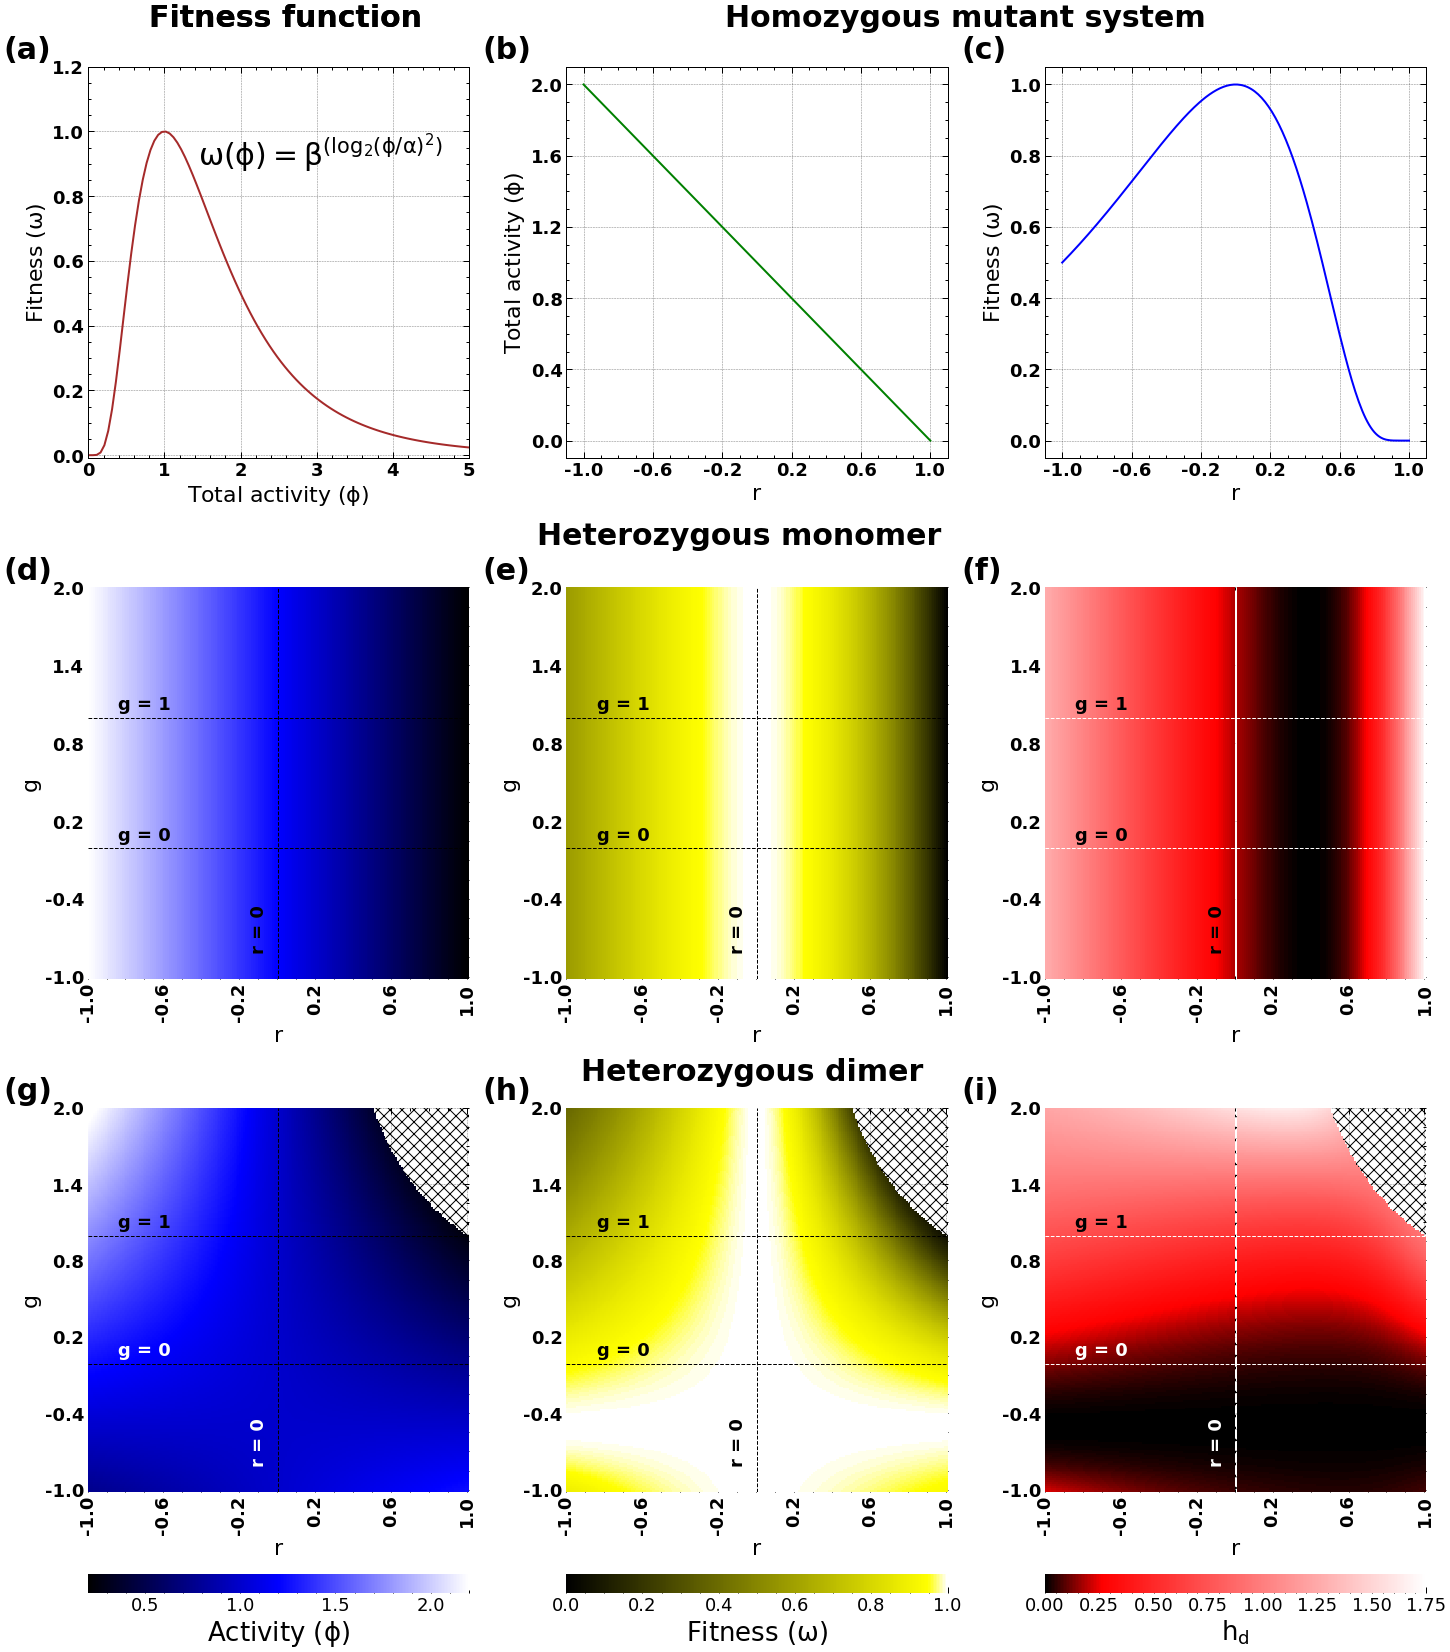

In [15]:
fig = plt.figure(figsize=(20, 24))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1.4], width_ratios=[1, 1, 1])

axs = {f"{i}{j}": fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)}

'''Fig 2A (Fitness function)'''

phi_range = np.linspace(0.01, 5, 100)
fit = [fitness_1(phi) for phi in phi_range]

axs00 = axs["00"]
axs00.plot(phi_range, fit, color="brown")
axs00.set_xlabel(r"Total activity ($\mathrm{\phi}$)", fontsize=22)
axs00.set_ylabel(r"Fitness ($\mathrm{\omega}$)", fontsize=22)
axs00.set(xlim=(-0.01, 5), ylim=(-0.01, 1.2))

# Set x and y ticks
xticks = np.arange(0, 6, 1)
yticks = np.arange(0, 1.4, 0.2)
axs00.set_xticks(xticks, labels=np.round(xticks, 1), fontsize=18, fontweight='bold')
axs00.set_yticks(yticks, labels=np.round(yticks, 1), fontsize=18, fontweight='bold')

# Legend and annotation
legend = axs00.legend([r"$\mathrm{\omega(\phi) = \beta^{(log_2(\phi/\alpha)^2)}}$"],
                      frameon=False, loc="upper right", fontsize=30,
                      bbox_to_anchor=(1.08, 0.98), borderaxespad=1.5)
for legend_handle in legend.legend_handles:
    legend_handle.set_visible(False)
axs00.annotate("(a)", xy=(-0.22, 1.02), xycoords="axes fraction", fontsize=30, fontweight='bold')

fig.text(0.1, 0.95, "Fitness function", fontsize=30, fontweight='bold')

'''Fig 2B - 2C (Activity and fitness for mutant homozygous genotypes)'''

r_vals = np.linspace(-1,1,201)

# list of data for both the plots
plots_info = [
    ("01", norm_d_homo_mut, "green", np.linspace(-1, 1, 6), np.linspace(0, 2, 6), "r", r"Total activity ($\mathrm{\phi}$)", "(b)"),
    ("02", fit1_d_homo_mut, "blue", np.linspace(-1, 1, 6), np.linspace(0, 1, 6), "r", r"Fitness ($\mathrm{\omega}$)", "(c)"),
]

for key, data, color, xticks, yticks, xlabel, ylabel, label in plots_info:
    ax = axs[key]
    ax.plot(r_vals, data, color=color)
    ax.set_xticks(xticks, labels=np.round(xticks, 1), fontsize=18, fontweight='bold')
    ax.set_yticks(yticks, labels=np.round(yticks, 1), fontsize=18, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
    ax.annotate(label, xy=(-0.22, 1.02), xycoords="axes fraction", fontsize=30, fontweight='bold')

'''Fig 2D - 2F (Activity, fitness, h_d heatmaps for heterozygous genotypes)'''

g_vals = np.linspace(-1,2,201)

# Create colormaps
cmap1 = LinearSegmentedColormap.from_list("cmap1", [(0.0,(0,0,0)),(0.5,(0,0,1)),(1.0,(1,1,1))])
cmap2 = LinearSegmentedColormap.from_list("cmap2", [(0.0,(0,0,0)),(0.95,(1,1,0)),(1.0,(1,1,1))])
cmap3 = LinearSegmentedColormap.from_list("cmap3", [(0.0,(0,0,0)),(0.15,(1,0,0)),(1.0,(1,1,1))])

# x- and y- labels and ticks
xlabel = "r"
ylabel = "g"
xticks = np.arange(0, len(r_vals), 40)
xticklabels = np.round(r_vals[::40], 1)
yticks = np.arange(0, len(g_vals), 40)
yticklabels = np.round(g_vals[::-40], 1)

# list with data for all heatmaps
heatmaps_info = [
    ("10", norm_m_hetero, cmap1, None, None, "(d)"),
    ("11", fit1_m_hetero, cmap2, None, None, "(e)"),
    ("12", h_m, cmap3, None, None, "(f)"),
    ("20", norm_d_hetero, cmap1, [0.2, 2.2], "Activity ($\mathrm{\phi}$)", "(g)"),
    ("21", fit1_d_hetero, cmap2, [0.0, 1.0], "Fitness ($\mathrm{\omega}$)", "(h)"),
    ("22", h_d, cmap3, [0.0, 1.75], "$\mathrm{h_d}$", "(i)")
]

for key, data, cmap, vrange, cbarlabel, label in heatmaps_info:
    ax = axs[key]
    if vrange == None:
        sns.heatmap(data, ax=ax, cmap=cmap, annot=False, cbar=False, rasterized = True)
    else:
        sns.heatmap(data, ax=ax, cmap=cmap, annot=False, zorder=2,
            vmin=vrange[0], vmax=vrange[1], cbar_kws={"pad":0.15, 'orientation':'horizontal'}, 
                   rasterized = True)

        # crossed-out mesh for disallowed regions on the heatmap
        im = ax.pcolormesh(data, edgecolors='black', linewidths=0, zorder=1)
        ax.patch.set(hatch='xx', edgecolor='black')

        # colorbar specifications
        cbar = ax.collections[0].colorbar
        cbar.set_label(label=cbarlabel, fontsize=26, loc='center')
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.tick_params(labelsize=18)
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')

    # x- and y-ticks
    ax.set_xticks(xticks, xticklabels, fontsize=18, fontweight='bold')
    ax.set_yticks(yticks, yticklabels, fontsize=18, fontweight='bold')

    # reference lines and text
    ax.axvline(x=len(r_vals)/2, color='white' if key[1] == '2' else 'black', linestyle='--', linewidth=1, label='r=0')
    ax.axhline(y=len(g_vals)/3, color='white' if key[1] == '2' else 'black', linestyle='--', linewidth=1, label='g=0')
    ax.axhline(y=2*len(g_vals)/3, color='white' if key[1] == '2' else 'black', linestyle='--', linewidth=1, label='g=1')

    ax.text(len(r_vals)/2 - 10, len(g_vals) - 15, 'r = 0', color='white' if key == '20' or key == '22' else 'black',
            ha='center', fontsize=18, fontweight='bold', rotation=90)
    ax.text(30, len(g_vals)/3 - 4, 'g = 1', color='black',
            ha='center', fontsize=18, fontweight='bold')
    ax.text(30, 2*len(g_vals)/3 - 4, 'g = 0', color='white' if key == '20' or key == '22' else 'black',
            ha='center', fontsize=18, fontweight='bold')

    # x-, y- labels and annotation
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
    ax.annotate(label, xy=(-0.22, 1.02), xycoords="axes fraction", fontsize=30, fontweight='bold')

fig.text(0.1,0.95,"Fitness function", fontsize=30, fontweight='bold')
fig.text(0.5,0.95,"Homozygous mutant system", fontsize=30, fontweight='bold')
fig.text(0.37,0.65,'Heterozygous monomer', fontsize=30, fontweight='bold')
fig.text(0.4,0.34,'Heterozygous dimer', fontsize=30, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.29)
plt.savefig("../Figures/Main_figures/Figure2.png", transparent=False, dpi=300, bbox_inches='tight')
plt.savefig("../Figures/Main_figures/Figure2.pdf", transparent=False, dpi=300, bbox_inches='tight')
plt.show()


## **Figure 3 (homodimerization effect)**

#### **Calculating relative activity, fitness, h for monomers and dimers**

In [16]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5
curr_binding_energy_AA = -10
curr_binding_energy_BB = -10
curr_binding_energy_AB = -10

# Default values of activity of individual species
aA = 0.1
aB = 0.1
aAA = 1
aAB = 1
aBB = 1
aA_m = 0.5
aB_m = 0.5

# Equilibrium concentrations

# Dimer
[cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB)
# Monomer
[cA_m, cB_m] = heterozygous_monomer(sA, sB, dA, dB, curr_stab_A, curr_stab_B)

# Optimal value of total activity

# Dimer
opt_act_d_hetero = aA*cA + aB*cB + aAA*cAA + aAB*cAB + aBB*cBB
# Monomer
opt_act_m_hetero = aA_m*cA_m + aB_m*cB_m

# Varying the values of r and g
r_vals = np.linspace(-1,1,201)
g_vals = np.linspace(-1,2,201)

# Output matrix
act_d_hetero = np.zeros((len(g_vals),len(r_vals)))
act_m_hetero = np.zeros((len(g_vals),len(r_vals)))
norm_d_hetero = np.zeros((len(g_vals),len(r_vals)))
norm_m_hetero = np.zeros((len(g_vals),len(r_vals)))
norm_r_hetero = np.zeros((len(g_vals),len(r_vals)))
fit1_r_hetero = np.zeros((len(g_vals),len(r_vals)))
h_r = np.zeros((len(g_vals),len(r_vals)))

# Calculating total activity and fitness for the given range of r and g values
for i, g in enumerate(g_vals):
    for j, r in enumerate(r_vals):

        # Checking for negative activity values (disallowed)
        if g*r <= 1 and r <= 1:
            aAB = 1 - g*r
            aBB = 1 - r
            aB_m = (1 - r)/2

            act_d_hetero[-i-1,j] = aAA*cAA + aAB*cAB + aBB*cBB + aA*cA + aB*cB
            norm_d_hetero[-i-1,j] = act_d_hetero[-i-1,j]/opt_act_d_hetero

            act_m_hetero[-i-1,j] = aA_m*cA_m + aB_m*cB_m
            norm_m_hetero[-i-1,j] = act_m_hetero[-i-1,j]/opt_act_m_hetero

            norm_r_hetero[-i-1,j] = norm_d_hetero[-i-1,j] - norm_m_hetero[-i-1,j]
            fit1_r_hetero[-i-1,j] = fitness_1(norm_d_hetero[-i-1,j]) - fitness_1(norm_m_hetero[-i-1,j])
            h_r[-i-1,j] = (-fit1_r_hetero[-i-1,j])/(s_m_homo_mut[j])


        else:
            act_d_hetero[-i-1,j] = np.nan
            act_m_hetero[-i-1,j] = np.nan
            norm_d_hetero[-i-1,j] = np.nan
            norm_m_hetero[-i-1,j] = np.nan
            norm_r_hetero[-i-1,j] = np.nan
            fit1_r_hetero[-i-1,j] = np.nan
            h_r[-i-1,j] = np.nan


#### **Plotting**

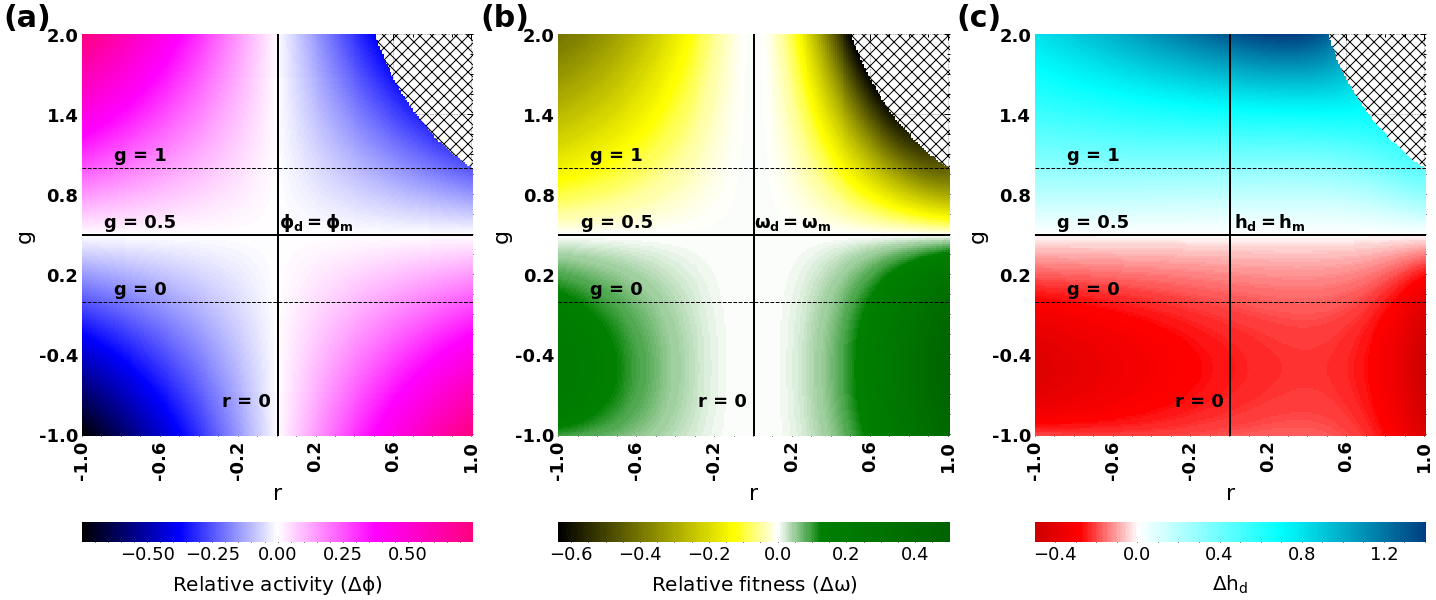

In [17]:
fig, axs = plt.subplots(1,3,figsize=(20,8.69))

xticks = np.arange(0, len(r_vals), 40)
xticklabels = np.round(r_vals[::40], 1)
yticks = np.arange(0, len(g_vals), 40)
yticklabels = np.round(g_vals[::-40], 1)

cmap11 = LinearSegmentedColormap.from_list("cmap11", [(0.0,(0,0,0)),(0.25,(0,0,1)),(0.5,(1,1,1)),(0.75,(1,0,1)),(1.0,(1,0,0.5))])
cmap21 = LinearSegmentedColormap.from_list("cmap21", [(0.0,(0,0,0)),(0.4,(1,1,0)),(0.5,(1,1,1)),(0.6,(0,0.5,0)),(1.0,(0,0.35,0))])
cmap31 = LinearSegmentedColormap.from_list("cmap31", [(0.0,(0,0,0)),(0.4,(1,0,0)),(0.5,(1,1,1)),(0.75,(0,1,1)),(1.0,(0,0.25,0.5))])

# list with data for all heatmaps
heatmaps_info1 = [
    (0, norm_r_hetero, cmap11, "Relative activity ($\mathrm{\Delta\phi}$)", "$\mathbf{\phi_d = \phi_m}$", "(a)"),
    (1, fit1_r_hetero, cmap21, "Relative fitness ($\mathrm{\Delta\omega}$)", "$\mathbf{\omega_d = \omega_m}$", "(b)"),
    (2, h_r, cmap31, "$\mathrm{\Delta h_d}$", "$\mathbf{h_d = h_m}$", "(c)")
]

for key, data, cmap, cbarlabel, intext, label in heatmaps_info1:
    ax = axs[key]
    sns.heatmap(data, zorder=2, ax=ax, cmap = cmap, center=0, annot=False,
                cbar_kws={"pad": 0.15, 'orientation': 'horizontal'}, 
               rasterized = True)

    # crossed-out mesh for disallowed regions on the heatmap
    im = ax.pcolormesh(data, edgecolors='black', linewidths=0, zorder=1)
    ax.patch.set(hatch='xx', edgecolor='black')

    # colorbar specifications
    cbar = ax.collections[0].colorbar
    cbar.set_label(label=cbarlabel, fontsize=20, loc='center', labelpad=10)
    cbar.ax.tick_params(labelsize=18)
    cbar.locator = MaxNLocator(nbins=6)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')

    # x-, y-ticks
    ax.set_xticks(xticks, xticklabels, fontsize=18, fontweight='bold')
    ax.set_yticks(yticks, yticklabels, fontsize=18, fontweight='bold')

    # reference lines and texts in-plot
    ax.axvline(x=len(r_vals)/2, color='black', linestyle='--', linewidth=1, label='r=0')
    ax.axhline(y=len(g_vals)/3, color='black', linestyle='--', linewidth=1, label='g=0')
    ax.axhline(y=2*len(g_vals)/3, color='black', linestyle='--', linewidth=1, label='g=1')
    ax.axvline(x=len(r_vals)/2, color='black', linestyle='-', linewidth=2, label='r=0')
    ax.axhline(y=len(g_vals)/2, color='black', linestyle='-', linewidth=2, label='g=0.5')

    ax.text(len(r_vals)/2 - 16, len(g_vals) - 15, 'r = 0', color='black', ha='center', fontsize=18, fontweight='bold')
    ax.text(30, len(g_vals)/3 - 4, 'g = 1', color='black', ha='center', fontsize=18, fontweight='bold')
    ax.text(30, 2*len(g_vals)/3 - 4, 'g = 0', color='black', ha='center', fontsize=18, fontweight='bold')
    ax.text(30, len(g_vals)/2 - 4, 'g = 0.5', color='black', ha='center', fontsize=18, fontweight='bold')
    ax.text(len(r_vals)/2 + 20, len(g_vals)/2 - 4, intext, color='black', ha='center', fontsize=18)

    # x-, y-labels and annotation
    ax.set_xlabel("r", fontsize=22)
    ax.set_ylabel("g", fontsize=22)
    ax.annotate(label, xy=(-0.20, 1.02), xycoords="axes fraction", fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig("../Figures/Main_figures/Figure3.png", transparent=False, dpi=300, bbox_inches='tight')
plt.savefig("../Figures/Main_figures/Figure3.pdf", transparent=False, dpi=300, bbox_inches='tight')
plt.show()


## **Figure 4 (changing equilibrium concentrations)**

#### **Homozygous mutant dimer**

In [18]:
# Solving the system for the following values of stability and binding energies
curr_stab_B = -5
curr_binding_energy_BB = -10

# Default values of activity of individual species
aB = 0.1
aBB = 1

# Equilibrium concentrations
[cB, cBB] = homozygous_dimer(sB, dB, dBB, curr_stab_B, curr_binding_energy_BB)

# Optimal value of total activity
opt_act_d_homo_mut = aB*cB + aBB*cBB

# Varying the value of r from -1 to 1
r_vals2 = [-0.5, 0.5]

# Output arrays to which activity and fitness values will be added
act_d_homo_mut_c = np.zeros(len(r_vals2))
norm_d_homo_mut_c = np.zeros(len(r_vals2))
fit1_d_homo_mut_c = np.zeros(len(r_vals2))
s_d_homo_mut_c = np.zeros(len(r_vals2))

# Calculating total activity and fitness for the given range of r values
for i,r in enumerate(r_vals2):

    # Checking for any negative activity values (disallowed)
    if r<=1:
        aBB = 1 - r
        act_d_homo_mut_c[i] = aB*cB + aBB*cBB
        norm_d_homo_mut_c[i] = act_d_homo_mut_c[i]/opt_act_d_homo_mut
        fit1_d_homo_mut_c[i] = fitness_1(norm_d_homo_mut_c[i])
        s_d_homo_mut_c[i] = 1 - fit1_d_homo_mut_c[i]

    else:
        act_d_homo_mut_c[i] = np.nan
        norm_d_homo_mut_c[i] = np.nan
        fit1_d_homo_mut_c[i] = np.nan
        s_d_homo_mut_c[i] = np.nan


#### **Heterozygous dimer system**

In [19]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5
curr_binding_energy_AA = -10
curr_binding_energy_BB = -10
curr_binding_energy_AB_default = -10
binding_energy_AB_vals = np.array([-11.301, -10.6505, -10.0, -9.3495, -8.699, -2.00])

# Default values of activity of individual species
aA = 0.1
aB = 0.1
aAA = 1
aAB = 1
aBB = 1

# Optimal value of total activity
[cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB_default)
opt_act_d_hetero = aA*cA + aB*cB + aAA*cAA + aAB*cAB + aBB*cBB

# Varying the values of r and g
g_vals = np.linspace(-1,2,201)
r_vals = [-0.5, 0.5]

# Empty arrays to which results will be appended
activity_c2 = []
fitness_c2 = []
h_c2 = []

for k, r in enumerate(r_vals):

    # Output matrix
    act_d_hetero_c2 = np.zeros((len(binding_energy_AB_vals),len(g_vals)))
    norm_d_hetero_c2 = np.zeros((len(binding_energy_AB_vals),len(g_vals)))
    fit1_d_hetero_c2 = np.zeros((len(binding_energy_AB_vals),len(g_vals)))
    h_d_c2 = np.zeros((len(binding_energy_AB_vals),len(g_vals)))

    for j, curr_binding_energy_AB in enumerate(binding_energy_AB_vals):
        for i, g in enumerate(g_vals):

            # Equilibrium concentrations
            [cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB)

            # Checking for negative activity values (disallowed)
            if g*r <= 1 and r <= 1:
                aAB = 1 - g*r
                aBB = 1 - r

                act_d_hetero_c2[j,i] = aAA*cAA + aAB*cAB + aBB*cBB + aA*cA + aB*cB
                norm_d_hetero_c2[j,i] = act_d_hetero_c2[j,i]/opt_act_d_hetero
                fit1_d_hetero_c2[j,i] = fitness_1(norm_d_hetero_c2[j,i])
                h_d_c2[j,i] = (1 - fit1_d_hetero_c2[j,i])/(s_d_homo_mut_c[k])

            else:
                act_d_hetero_c2[j,i] = np.nan
                norm_d_hetero_c2[j,i] = np.nan
                fit1_d_hetero_c2[j,i] = np.nan
                h_d_c2[j,i] = np.nan

    activity_c2.append(norm_d_hetero_c2)
    fitness_c2.append(fit1_d_hetero_c2)
    h_c2.append(h_d_c2)


#### **Plotting**

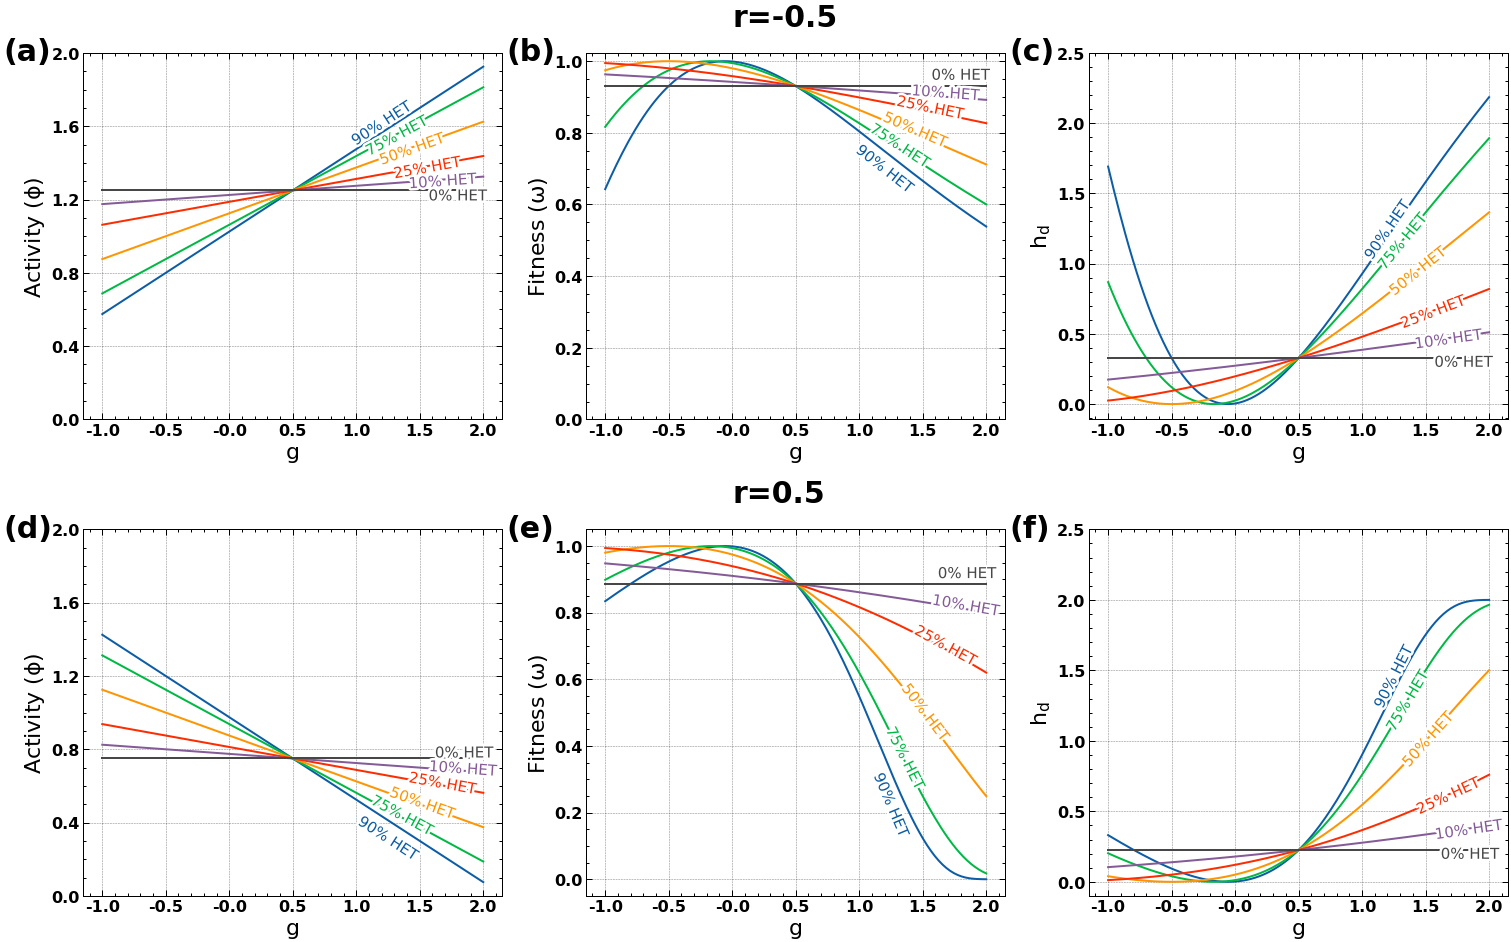

In [20]:
percent_Het = ["90%", "75%", "50%", "25%", "10%", "0%"]
fig = plt.figure(figsize=(21,13.5))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1,1], width_ratios=[1,1,1])

panelnumbers = [['a', 'b', 'c'], ['d', 'e', 'f']]
r_vals = [-0.5, 0.5]

act_ticks = [np.linspace(0,2,6), np.linspace(0,2,6)]
fit_ticks = [np.linspace(0,1,6), np.linspace(0,1,6)]
h_ticks   = [np.linspace(0,2.5,6), np.linspace(0,2.5,6)]


xticks = np.linspace(-1, 2, 7)
xticklabels = np.round(g_vals[::33], 1)

axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

for i in range(2):
    for j in range(3):
        ax = axs[i][j]

        data = [activity_c2, fitness_c2, h_c2][j]
        ylabel = ["Activity ($\mathrm{\phi}$)", "Fitness ($\mathrm{\omega}$)", "$\mathrm{h_d}$"][j]
        yticks, yticklabels = (act_ticks[i], np.round(act_ticks[i], 1)) if j == 0 else \
                              (fit_ticks[i], np.round(fit_ticks[i], 1)) if j == 1 else \
                              (h_ticks[i], np.round(h_ticks[i], 1))

        for k, p in enumerate(percent_Het):
            ax.plot(g_vals, data[i][k], label=f"{p} HET")

        ax.set_ylabel(ylabel, fontsize=22)
        ax.set_yticks(yticks, yticklabels, fontweight='bold')
        ax.set_xlabel("g", fontsize=22)
        ax.set_xticks(xticks, xticklabels, fontweight='bold')

        ax.annotate(f"({panelnumbers[i][j]})", xy=(-0.19, 0.98),
                    xycoords="axes fraction", fontsize=30, fontweight='bold')

        lines = ax.get_lines()
        if i == 0:
            yoffsets = [-0.05, 0.01] if j == 1 else [0.05, -0.01]
            labelLines(lines[:1], yoffsets=yoffsets[0], fontsize=15, xvals=1.2)
            labelLines(lines[1:5], yoffsets=yoffsets[1], fontsize=15, xvals=(1.2, 1.8))
            labelLines(lines[5:], yoffsets=yoffsets[1]*3, fontsize=15, xvals=1.8)
        else:
            yoffsets = [0.1, -0.01] if j == 2 else [-0.1, 0.01]
            labelLines(lines[:1], yoffsets=yoffsets[0], fontsize=15, xvals=(1.2, 1.3))
            labelLines(lines[1:5], yoffsets=yoffsets[1], fontsize=15, xvals=(1.2, 2))
            labelLines(lines[5:], yoffsets=yoffsets[1]*3, fontsize=15, xvals=(1.7, 2))
            

fig.text(0.48, 0.95, "r=-0.5", fontsize=30, fontweight='bold')
fig.text(0.48, 0.46, "r=0.5", fontsize=30, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.savefig("../Figures/Main_figures/Figure4.png", transparent=False, dpi=300, bbox_inches='tight')
plt.savefig("../Figures/Main_figures/Figure4.pdf", transparent=False, dpi=300, bbox_inches='tight')
plt.show()


#### Figure 5

In [21]:
## Generate a dataset with random samples of s and h_d

# Sample s
np.random.seed(123)
mu_s1, sigma_s1 = 0, 0.25
s_list1 = np.random.normal(mu_s1, sigma_s1, 1000)

mu_s2, sigma_s2 = 1, 0.25
s_list2 = np.random.normal(mu_s2, sigma_s2, 1000)

s_list = np.concatenate((s_list1, s_list2),0)

# Sample h
mu_h, sigma_h = 0, 0.25
h_list = np.random.normal(mu_h, sigma_h, 2000)

df = pd.DataFrame(zip(s_list, h_list), columns = ['s', 'h_d'])
df

,s,h_d
0,-0.271408,-0.443556
1,0.249336,-0.300344
2,0.070745,0.274064
3,-0.376574,0.215259
4,-0.144650,-0.380092
...,...,...
1995,1.211425,-0.226988
1996,0.720019,-0.454511
1997,0.910176,-0.030683
1998,0.597576,0.448622


In [22]:
## Add a control with the same fitness as the wt
df.loc[len(df)] = [0, 0]

## Add columns for the total fitness of homo- and heterozygotes
df['fitness_homozygote'] = 1 - df['s']
df['fitness_heterozygote'] = 1 - df['h_d']*df['s']

df

,s,h_d,fitness_homozygote,fitness_heterozygote
0,-0.271408,-0.443556,1.271408,0.879616
1,0.249336,-0.300344,0.750664,1.074887
2,0.070745,0.274064,0.929255,0.980611
3,-0.376574,0.215259,1.376574,1.081061
4,-0.144650,-0.380092,1.144650,0.945020
...,...,...,...,...
1996,0.720019,-0.454511,0.279981,1.327257
1997,0.910176,-0.030683,0.089824,1.027927
1998,0.597576,0.448622,0.402424,0.731914
1999,1.003393,-0.080127,-0.003393,1.080399


In [23]:
## Calculate total activity using different fitness functions
## assuming 50% homodimers and 50% heterodimers

total_dimers = 1 # So that it is normalized to 1 along the x-axis

def hill_func(x, a, b, c):
    '''
    A Hill fitness function. Arguments are:
    - x: the total activity of the system
    - a: Maximum growth rate
    - b: Hill coefficient
    - c: Coefficient in the denominator, analogous to K_50
    '''
    return  a * np.power(x, b) / (np.power(c, b) + np.power(x, b))

# Define inverse Hill function
def inverse_hill(fitness, a, b, c):
    '''
    The inverse function of the fitness function above (func). Arguments are:
    - fitness: The fitness rate for a given genotype
    - a: The coefficient for the numerator of the Hill equation (analogous to the maximum growth rate)
    - b: The Hill coefficient
    - c: The coefficient in the denominator (analogous to the K_50)
    '''
    numerator = np.power(c, b) * fitness
    denominator = a - fitness
    
    x = np.power(numerator / denominator, 1/b)
    return(x)


#### Initialize the parameters for the different fitness functions

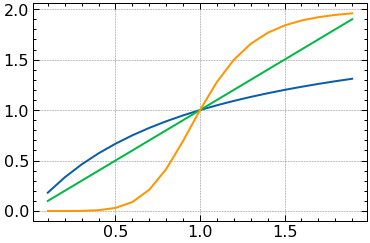

In [24]:
## Params fitness function 1 (Hill function, insensitive to activity changes)
a_1 = 2
b_1 = 1 
c_1 = 1

## Params fitness function 2 (linear function, y = mx + b) 
m_2 = 1
b_2 = 0

## Params fitness function 3 (Hill function, highly sensitive to activity changes)
a_3 = 2
b_3 = 6
c_3 = 1

## Draw the fitness functions
x_vals = np.arange(0.1, 2, 0.1)

# Function 1
plt.plot(x_vals, hill_func(x_vals, a_1, b_1, c_1))

# Function 2
plt.plot(x_vals, m_2*x_vals + b_2)

# Function 3
plt.plot(x_vals, hill_func(x_vals, a_3, b_3, c_3))

In [25]:
## Initialize a new list of solutions with these fitness functions
list_hill = [None]*3

#### Fitness function 1 ####

hill_coeff = b_1
df_hill = df.copy()

# Get the fitness for the different values in the data frame
df_hill['activity_heterozygote'] = inverse_hill(df_hill['fitness_heterozygote'], a_1, hill_coeff, c_1)
df_hill['activity_homozygote'] = inverse_hill(df_hill['fitness_homozygote'], a_1, hill_coeff, c_1)

# Calculate s and h_d
df_hill['r'] = 1 - (df_hill['activity_homozygote'] / total_dimers)

term_numerator = df_hill['activity_heterozygote'] - 0.25*total_dimers - 0.25*total_dimers*(1 - df_hill['r'])
term_denominator = df_hill['r']*0.5*total_dimers
df_hill['g'] = 1/df_hill['r'] - (term_numerator / term_denominator)

list_hill[0] = df_hill

#### Fitness function 2 ####

df_hill = df.copy()

# Get the fitness for the different values in the data frame
df_hill['activity_heterozygote'] = (df_hill['fitness_heterozygote'] - b_2) / m_2
df_hill['activity_homozygote'] = (df_hill['fitness_homozygote'] - b_2) / m_2

# Calculate s and h_d
df_hill['r'] = 1 - (df_hill['activity_homozygote'] / total_dimers)

term_numerator = df_hill['activity_heterozygote'] - 0.25*total_dimers - 0.25*total_dimers*(1 - df_hill['r'])
term_denominator = df_hill['r']*0.5*total_dimers
df_hill['g'] = 1/df_hill['r'] - (term_numerator / term_denominator)

list_hill[1] = df_hill
    
#### Fitness function 3 ####

hill_coeff = b_3
df_hill = df.copy()

# Get the fitness for the different values in the data frame
df_hill['activity_heterozygote'] = inverse_hill(df_hill['fitness_heterozygote'], a_3, hill_coeff, c_3)
df_hill['activity_homozygote'] = inverse_hill(df_hill['fitness_homozygote'], a_3, hill_coeff, c_3)

# Calculate s and h_d
df_hill['r'] = 1 - (df_hill['activity_homozygote'] / total_dimers)

term_numerator = df_hill['activity_heterozygote'] - 0.25*total_dimers - 0.25*total_dimers*(1 - df_hill['r'])
term_denominator = df_hill['r']*0.5*total_dimers
df_hill['g'] = 1/df_hill['r'] - (term_numerator / term_denominator)

list_hill[2] = df_hill
    
len(list_hill)

3

Prepare the dataframe to compare the values of h_d and g for each fitness function (panel C)

In [26]:
## Gather all the h and g values
list_hill[0]['g_fit1'] = list_hill[0]['g']
list_hill[1]['g_fit2'] = list_hill[1]['g']
list_hill[2]['g_fit3'] = list_hill[2]['g']

df_all_vals = list_hill[0][['h_d', 'g_fit1']]
df_all_vals['g_fit2'] = list_hill[1]['g_fit2']
df_all_vals['g_fit3'] = list_hill[2]['g_fit3']

df_all_vals

<ipython-input-26-bbdc0750f315>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_vals['g_fit2'] = list_hill[1]['g_fit2']
<ipython-input-26-bbdc0750f315>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_vals['g_fit3'] = list_hill[2]['g_fit3']


,h_d,g_fit1,g_fit2,g_fit3
0,-0.443556,-1.076894,-1.387112,-1.312899
1,-0.300344,-1.311211,-1.100689,-1.122242
2,0.274064,0.075743,0.048128,0.051985
3,0.215259,-0.207928,-0.069482,-0.111005
4,-0.380092,-1.116337,-1.260184,-1.230694
...,...,...,...,...
1996,-0.454511,-2.824120,-1.409022,-1.418602
1997,-0.030683,-0.620588,-0.561366,-0.546867
1998,0.448622,0.630376,0.397243,0.352706
1999,-0.080127,-0.849122,-0.660255,NaN


#### Draw figure 5

<ipython-input-27-f346e6f2627d>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_yticklabels(axs[0,0].get_yticks(), size=ax_tick_size, weight='bold')
<ipython-input-27-f346e6f2627d>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(axs[0,0].get_xticks(), size=ax_tick_size, weight='bold')
<ipython-input-27-f346e6f2627d>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_yticklabels(axs[0,1].get_yticks(), size=ax_tick_size, weight='bold')
<ipython-input-27-f346e6f2627d>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(axs[0,1].get_xticks(), size=ax_tick_size, weight='bold')
<ipython-input-27-f346e6f2627d>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 2].set_yticklabels(axs[0,2].get_yticks(), size=ax_tick_size, weight='bold')
<ipython-input-27-f3

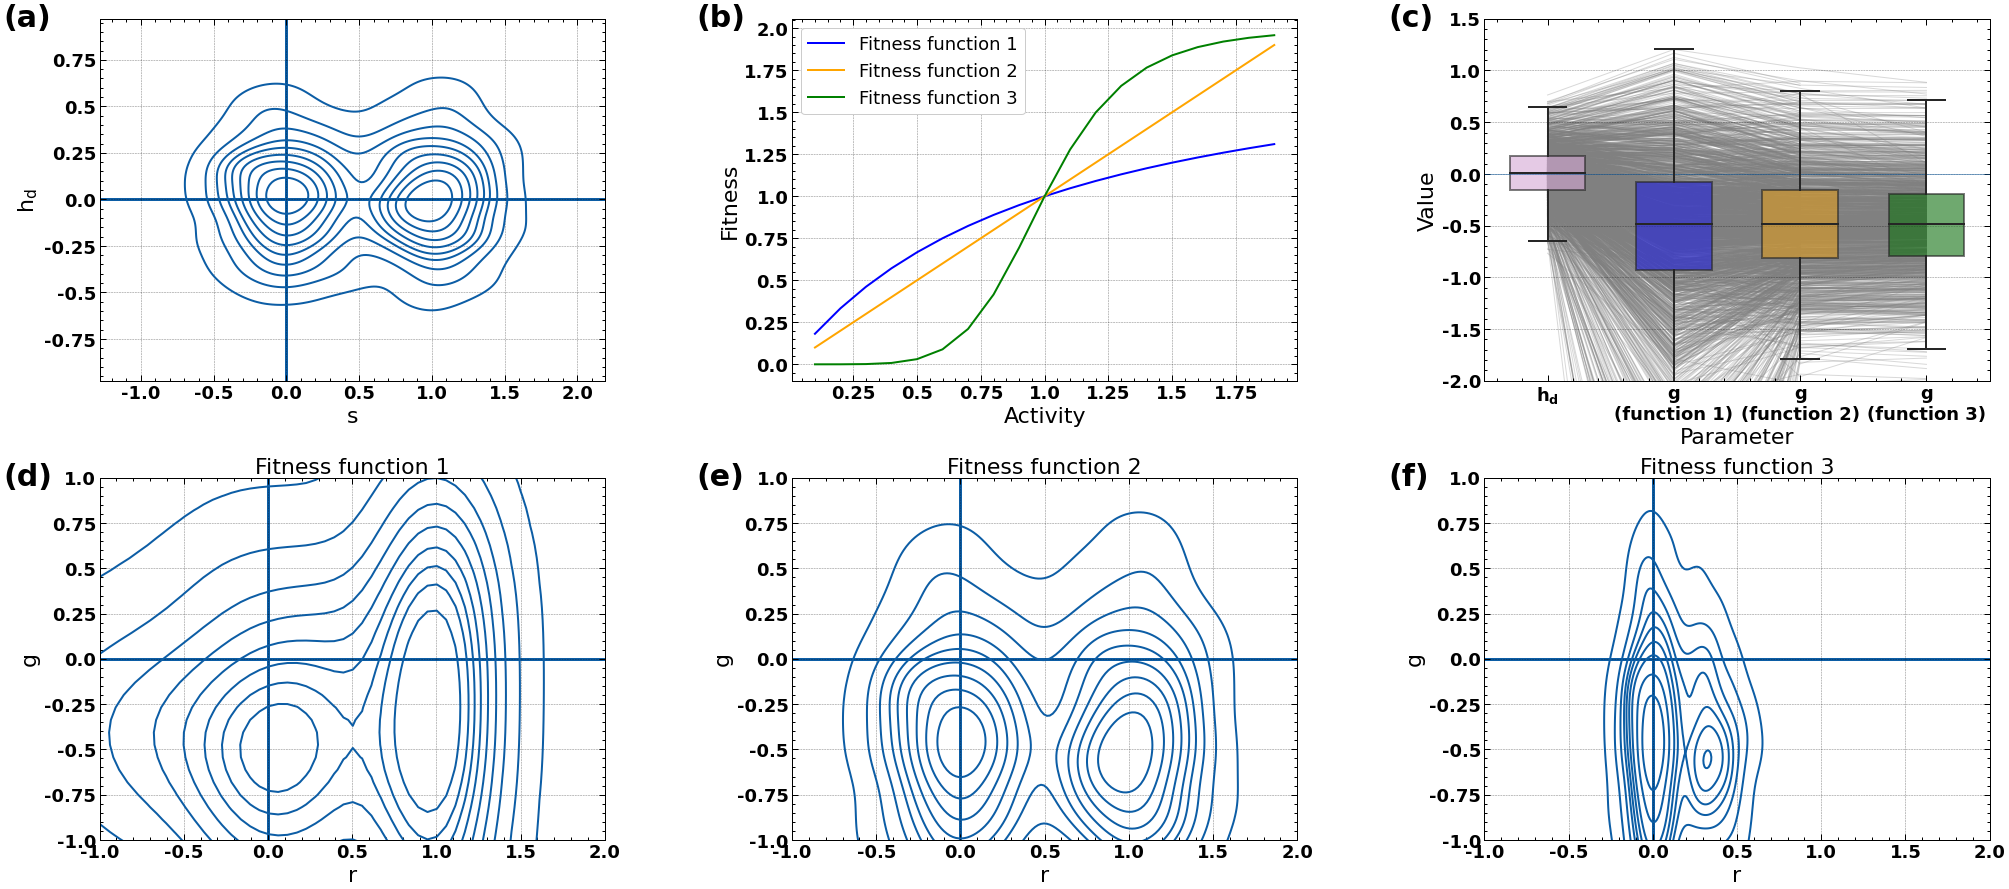

In [27]:
## Initialize layout
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(29)
fig.set_figheight(12.5)

fig.subplots_adjust(right = 1.5, top = 1.5)

ax_title_size = 22
ax_tick_size = 18
panel_label_size = 30

plt.rcParams['axes.titlepad'] = -20

#### Panel A ####

sns.kdeplot(data=df, ax = axs[0, 0], x="s", y="h_d")
axs[0, 0].axhline(y=0,xmin=-1,xmax=1,linewidth=0.5,zorder=0)
axs[0, 0].axvline(x=0,ymin=-1,ymax=1,linewidth=0.5,zorder=0)
axs[0, 0].set_xlabel('s', fontsize = ax_title_size)
axs[0, 0].set_ylabel('$\mathdefault{h_d}$', fontsize = ax_title_size)
axs[0, 0].set_yticklabels(axs[0,0].get_yticks(), size=ax_tick_size, weight='bold')
axs[0, 0].set_xticklabels(axs[0,0].get_xticks(), size=ax_tick_size, weight='bold')

axs[0, 0].axhline(y=0,xmin=-1,xmax=1,linewidth=3,zorder=0)
axs[0, 0].axvline(x=0,ymin=-1,ymax=1,linewidth=3,zorder=0)
axs[0, 0].annotate(f"(a)", xy=(-0.19, 0.98),
                    xycoords="axes fraction", fontsize=30, fontweight='bold')

#### Panel B #### 

x_vals = np.arange(0.1, 2, 0.1)

axs[0, 1].plot(x_vals, hill_func(x_vals, a_1, b_1, c_1), color = 'b') # Function 1
axs[0, 1].plot(x_vals, m_2*x_vals + b_2, color = 'orange') # Function 2
axs[0, 1].plot(x_vals, hill_func(x_vals, a_3, b_3, c_3), color = 'g') # Function 3

axs[0, 1].set_xlabel('Activity', fontsize = ax_title_size)
axs[0, 1].set_ylabel('Fitness', fontsize = ax_title_size)
axs[0, 1].set_yticklabels(axs[0,1].get_yticks(), size=ax_tick_size, weight='bold')
axs[0, 1].set_xticklabels(axs[0,1].get_xticks(), size=ax_tick_size, weight='bold')

axs[0, 1].legend(['Fitness function 1', 'Fitness function 2', 'Fitness function 3'], fontsize = ax_tick_size)
axs[0, 1].annotate(f"(b)", xy=(-0.19, 0.98),
                    xycoords="axes fraction", fontsize=30, fontweight='bold')

#### Panel C ####

# Pivot to a longer data frame
df_all_vals_long = pd.melt(df_all_vals)

## Add lines to pair values
for i in df_all_vals.index:
    subset = df_all_vals.iloc[i]
    sns.lineplot(data = subset, linewidth = 1, label = "_nolegend", color = 'gray', alpha = 0.3, 
                zorder = 0, ax = axs[0, 2])

box_palette = ['plum', 'b', 'orange', 'g']
sns.boxplot(data = df_all_vals_long, width = 0.6, ax = axs[0, 2],
            showfliers = False, x = 'variable', y = 'value', zorder = 2,
            boxprops = {'alpha':0.6}, palette=box_palette)
            
    
axs[0, 2].axhline(y=0,xmin=-1,xmax=1,linewidth=0.5,zorder=1)
axs[0, 2].set_ylim([-2, 1.5])
axs[0, 2].set_xlabel('Parameter', fontsize = ax_title_size)
axs[0, 2].set_ylabel('Value', fontsize = ax_title_size)
axs[0, 2].set_yticklabels(axs[0,2].get_yticks(), size=ax_tick_size, weight='bold')
axs[0, 2].set_xticklabels(['$\mathdefault{h_d}$', 'g\n(function 1)', 'g\n(function 2)', 'g\n(function 3)'],
                          size=ax_tick_size, weight='bold')
axs[0, 2].annotate(f"(c)", xy=(-0.19, 0.98),
                    xycoords="axes fraction", fontsize=30, fontweight='bold')

#### Panels D-F ####

panel_labels = ['(d)', '(e)', '(f)']

for i in range(len(list_hill)):
    
    data_fig = list_hill[i]
    
    axs[1, i].set_title('Fitness function ' + str(i+1), fontsize = ax_title_size)
    sns.kdeplot(ax = axs[1, i], data = data_fig, x = 'r', y = 'g')
    
    axs[1, i].set_xlim([-1, 2])
    axs[1, i].set_ylim([-1, 1])
    axs[1, i].axhline(y=0,xmin=-1,xmax=1,linewidth=3,zorder=0)
    axs[1, i].axvline(x=0,ymin=-1,ymax=1,linewidth=3,zorder=0)
    axs[1, i].set_xlabel('r', fontsize = ax_title_size)
    axs[1, i].set_ylabel('g', fontsize = ax_title_size)
    axs[1, i].set_yticklabels(axs[1, i].get_yticks(), size=ax_tick_size, weight='bold')
    axs[1, i].set_xticklabels(axs[1, i].get_xticks(), size=ax_tick_size, weight='bold')
    axs[1, i].annotate(f"{panel_labels[i]}", xy=(-0.19, 0.98),
                    xycoords="axes fraction", fontsize=30, fontweight='bold')


fig.tight_layout()
fig.savefig('../Figures/Main_figures/Figure5.png', dpi = 300)
fig.savefig('../Figures/Main_figures/Figure5.pdf', dpi = 300)



## **Figure S1 (plotting heatmaps as a function of $(\Delta G_{bind,HET−HM},g)$, keeping $r$ fixed)**

#### **Mutant homozygous system**

In [28]:
# Solving the system for the following values of stability and binding energies
curr_stab_B = -5
curr_binding_energy_BB = -10

# Default values of activity of individual species
aB = 0.1
aBB = 1

# Equilibrium concentrations
[cB, cBB] = homozygous_dimer(sB, dB, dBB, curr_stab_B, curr_binding_energy_BB)

# Optimal value of total activity
opt_act_d_homo_mut = aB*cB + aBB*cBB

# Varying the value of r from -1 to 1
r_vals = [-0.5, 0.1, 0.5]

# Output arrays to which activity and fitness values will be added
act_d_homo_mut_c = np.zeros(len(r_vals))
norm_d_homo_mut_c = np.zeros(len(r_vals))
fit1_d_homo_mut_c = np.zeros(len(r_vals))
s_d_homo_mut_c = np.zeros(len(r_vals))

# Calculating total activity and fitness for the given range of r values
for i,r in enumerate(r_vals):

    # Checking for any negative activity values (disallowed)
    if r<=1:
        aBB = 1 - r
        act_d_homo_mut_c[i] = aB*cB + aBB*cBB
        norm_d_homo_mut_c[i] = act_d_homo_mut_c[i]/opt_act_d_homo_mut
        fit1_d_homo_mut_c[i] = fitness_1(norm_d_homo_mut_c[i])
        s_d_homo_mut_c[i] = 1 - fit1_d_homo_mut_c[i]

    else:
        act_d_homo_mut_c[i] = np.nan
        norm_d_homo_mut_c[i] = np.nan
        fit1_d_homo_mut_c[i] = np.nan
        s_d_homo_mut_c[i] = np.nan


#### **Heterozygous system**

In [29]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5
curr_binding_energy_AA = -10
curr_binding_energy_BB = -10
curr_binding_energy_AB_default = -10
curr_binding_energy_AB_vals = np.linspace(-15,-5,201)

# Default values of activity of individual species
aA = 0.1
aB = 0.1
aAA = 1
aAB = 1
aBB = 1

# Optimal value of total activity
[cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB_default)
opt_act_d_hetero = aA*cA + aB*cB + aAA*cAA + aAB*cAB + aBB*cBB

# Varying the values of r and g
g_vals = np.linspace(-1,2,201)
r_vals = [-0.5, 0.1, 0.5]

# Empty arrays to which results will be appended
activity_c = []
fitness_c = []
h_c = []

for k, r in enumerate(r_vals):

    # Output matrix
    act_d_hetero_c = np.zeros((len(g_vals),len(curr_binding_energy_AB_vals)))
    norm_d_hetero_c = np.zeros((len(g_vals),len(curr_binding_energy_AB_vals)))
    fit1_d_hetero_c = np.zeros((len(g_vals),len(curr_binding_energy_AB_vals)))
    h_d_c = np.zeros((len(g_vals),len(curr_binding_energy_AB_vals)))

    for i, g in enumerate(g_vals):
        for j, curr_binding_energy_AB in enumerate(curr_binding_energy_AB_vals):

            # Equilibrium concentrations
            [cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB)

            # Checking for negative activity values (disallowed)
            if g*r <= 1 and r <= 1:
                aAB = 1 - g*r
                aBB = 1 - r

                act_d_hetero_c[-i-1,j] = aAA*cAA + aAB*cAB + aBB*cBB + aA*cA + aB*cB
                norm_d_hetero_c[-i-1,j] = act_d_hetero_c[-i-1,j]/opt_act_d_hetero
                fit1_d_hetero_c[-i-1,j] = fitness_1(norm_d_hetero_c[-i-1,j])
                h_d_c[-i-1,j] = (1 - fit1_d_hetero_c[-i-1,j])/(s_d_homo_mut_c[k])

            else:
                act_d_hetero_c[-i-1,j] = np.nan
                norm_d_hetero_c[-i-1,j] = np.nan
                fit1_d_hetero_c[-i-1,j] = np.nan
                h_d_c[-i-1,j] = np.nan

    activity_c.append(norm_d_hetero_c)
    fitness_c.append(fit1_d_hetero_c)
    h_c.append(h_d_c)


#### **Plotting**

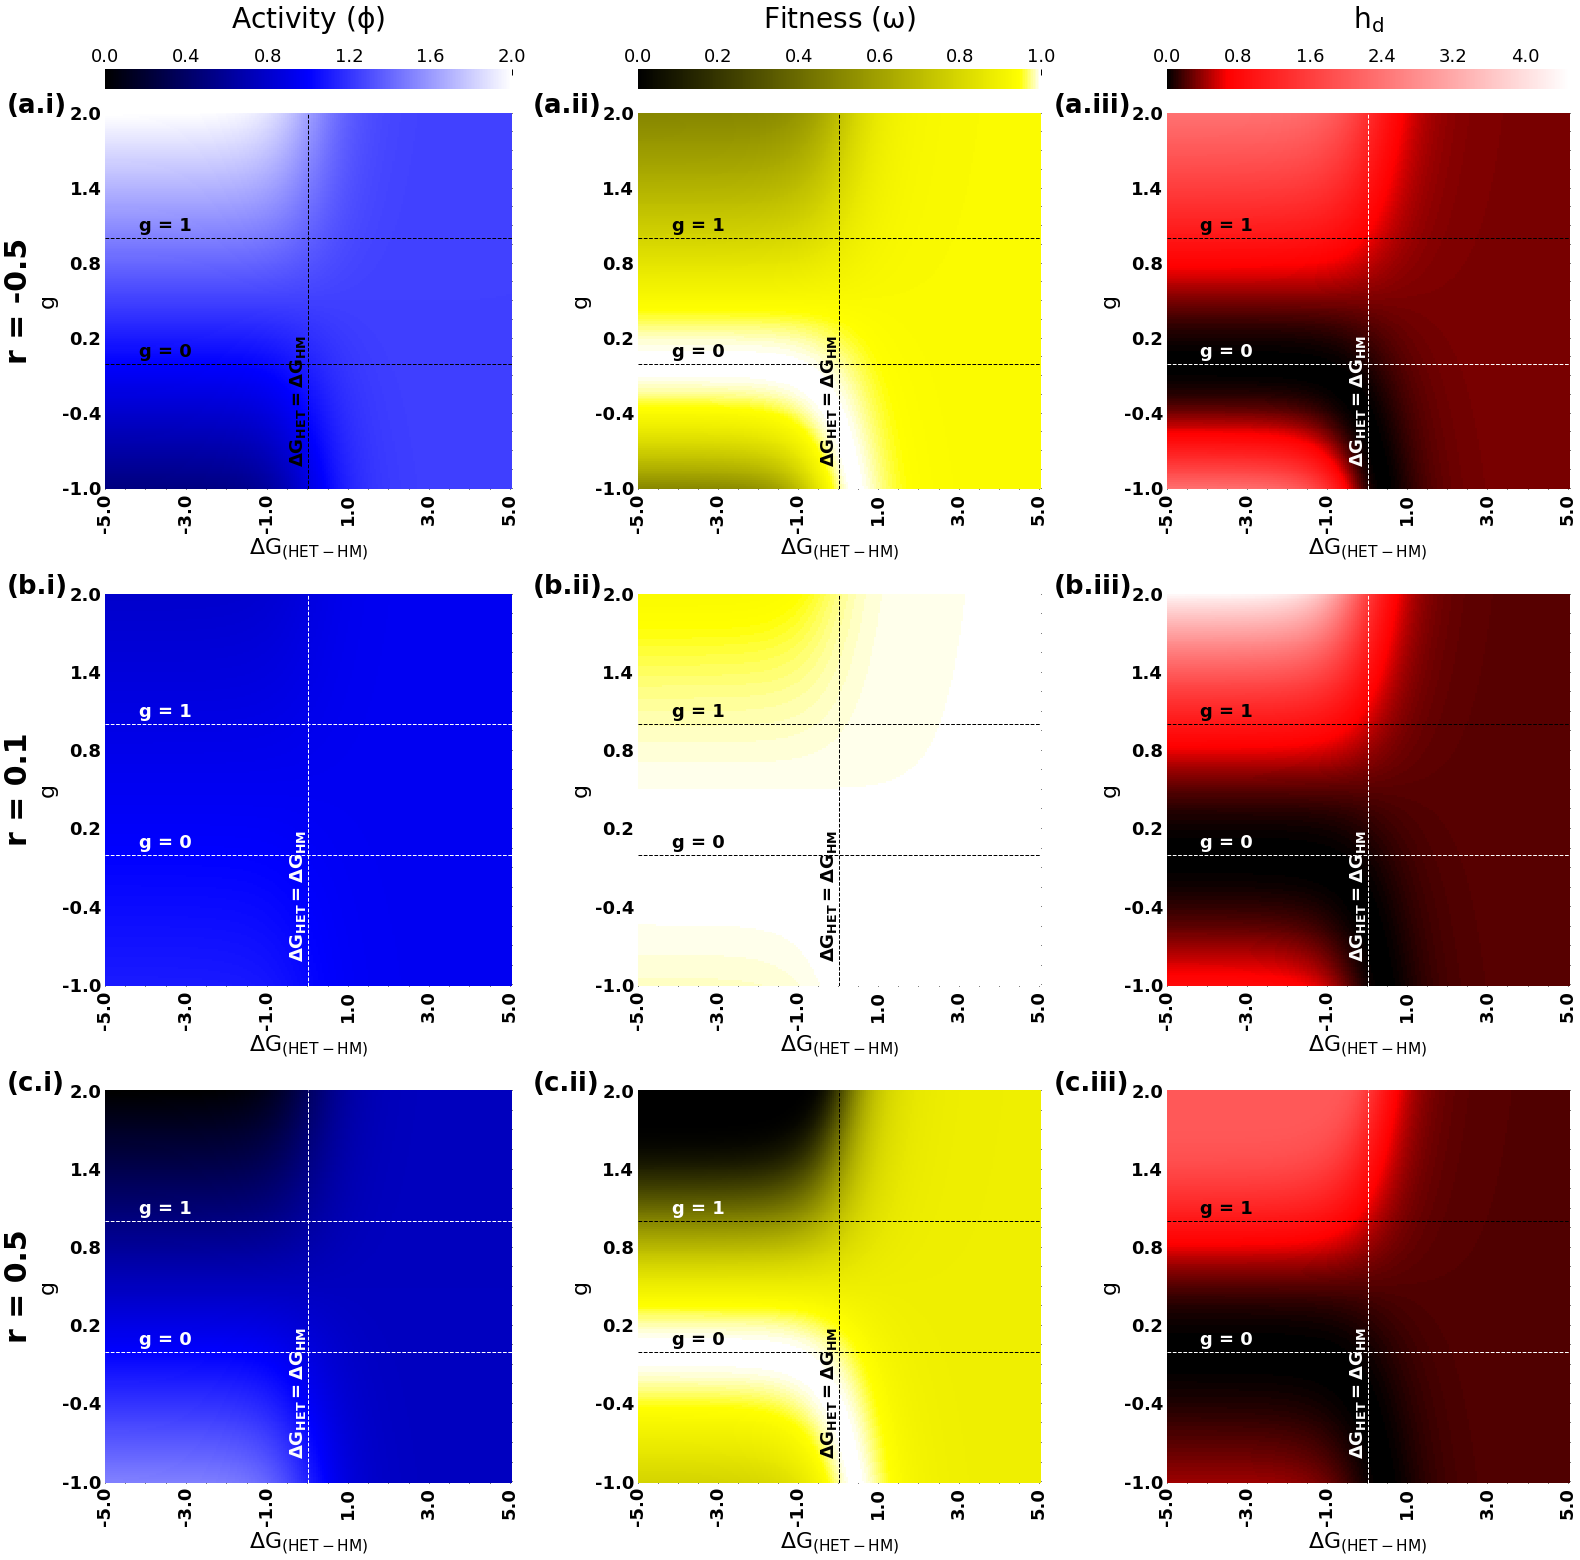

In [30]:
fig = plt.figure(figsize=(22, 22))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1.2, 1, 1], width_ratios=[1.01, 1, 1])

axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)])

romans = ['i','ii','iii']
alphabet = ['a','b','c']
panelnumbers=[[f'{x}.{y}' for y in romans] for x in alphabet]

xticks = np.arange(0, len(curr_binding_energy_AB_vals), 40)
xticklabels = np.round(curr_binding_energy_AB_vals[::40] - curr_binding_energy_AA, 1)
yticks = np.arange(0, len(g_vals), 40)
yticklabels = np.round(g_vals[::-40], 1)

cmap12 = LinearSegmentedColormap.from_list("cmap1", [(0.0,(0,0,0)),(0.5,(0,0,1)),(1.0,(1,1,1))])
cmap22 = LinearSegmentedColormap.from_list("cmap2", [(0.0,(0,0,0)),(0.95,(1,1,0)),(1.0,(1,1,1))])
cmap32 = LinearSegmentedColormap.from_list("cmap3", [(0.0,(0,0,0)),(0.15,(1,0,0)),(1.0,(1,1,1))])

# Plot heatmaps and configure subplots
for i in range(3):
    for j in range(3):
        ax = axs[i, j]

        # Select data and colormap
        if j == 0:
            data, cmap, vmin, vmax, label = activity_c[i], cmap12, 0, 2, "Activity ($\\mathrm{\\phi}$)"
        elif j == 1:
            data, cmap, vmin, vmax, label = fitness_c[i], cmap22, 0, 1, "Fitness ($\\mathrm{\\omega}$)"
        else:
            data, cmap, vmin, vmax, label = h_c[i], cmap32, 0, 4.5, "$\\mathrm{h_d}$"

        if i == 0:
            cbar_kws = {'location': 'top'}
            sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, cbar_kws=cbar_kws, 
                       rasterized = True)

            # colorbar specifications
            cbar = ax.collections[0].colorbar
            cbar.set_label(label=label, fontsize=28, loc='center', labelpad=20)
            cbar.ax.tick_params(labelsize=18)
            cbar.locator = MaxNLocator(nbins=6)
            cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            for label in cbar.ax.get_yticklabels():
                label.set_fontweight('bold')

        else:
            sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, cbar=False, 
                       rasterized = True)


        # Set axis labels and ticks
        ax.set_xticks(xticks, xticklabels, fontsize=18, fontweight='bold')
        ax.set_yticks(yticks, yticklabels, fontsize=18, fontweight='bold')
        ax.set_xlabel("$\\mathrm{\\Delta G_{(HET - HM)}}$", fontsize=22)
        ax.set_ylabel("g", fontsize=22)

        ## reference lines and text

        # deltaG annotation
        ax.text(len(curr_binding_energy_AB_vals)/2 - 5, len(g_vals) - 15, "$\\mathbf{\\Delta G_{HET} = \\Delta G_{HM}}$",
                color='white' if (j==2 or (j==0 and i in [1, 2])) else 'black', ha='center', fontsize=18, fontweight='bold', rotation=90)
        ax.axvline(x=len(curr_binding_energy_AB_vals)/2, 
                   color='white' if (j==2 or (j==0 and i in [1, 2])) else 'black',
                   linestyle='--', linewidth=1, label='$\\mathbf{\\Delta G_{HET} = \\Delta G_{HM}}$')


        # g = 0
        ax.text(30, 2*len(g_vals)/3 - 4, 'g = 0', color='white' if (j==2 or (j==0 and i in [1, 2]))  else 'black', ha='center', fontsize=18, fontweight='bold')
        ax.axhline(y=2*len(g_vals)/3, color='white' if (j==2 or (j==0 and i in [1, 2])) else 'black', linestyle='--', linewidth=1, label='g=0')
        
        # g = 1
        ax.text(30, len(g_vals)/3 - 4, 'g = 1', color='white' if ((i==2 and j in [0,1]) or (j==0 and i in [1, 2])) else 'black', ha='center', fontsize=18, fontweight='bold')
        ax.axhline(y=len(g_vals)/3, color='white' if (j==0 and i in [1, 2]) else 'black', linestyle='--', linewidth=1, label='g=1')


        # Add panel annotations
        ax.annotate(f"({panelnumbers[i][j]})", xy=(-0.24-0.02*j, 1), xycoords="axes fraction", fontsize=26, fontweight='bold')

        if j == 0:
            ax.text(-50, 100, f"r = {r_vals[i]}", color='black', va='center', rotation=90, fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig("../Figures/Supp_figures/FigureS1.png", transparent=False, dpi=300, bbox_inches='tight')
plt.savefig("../Figures/Supp_figures/FigureS1.pdf", transparent=False, dpi=300, bbox_inches='tight')
plt.show()


## **Figure S2 (plotting heatmaps as a function of $(\Delta G_{bind,HET−HM},r)$, keeping $g$ fixed)**

#### **Heterozygous system**

In [31]:
# Solving the system for the following values of stability and binding energies
curr_stab_A = -5
curr_stab_B = -5
curr_binding_energy_AA = -10
curr_binding_energy_BB = -10
curr_binding_energy_AB_default = -10
curr_binding_energy_AB_vals = np.linspace(-15,-5,201)

# Default values of activity of individual species
aA = 0.1
aB = 0.1
aAA = 1
aAB = 1
aBB = 1

# Optimal value of total activity
[cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB_default)
opt_act_d_hetero = aA*cA + aB*cB + aAA*cAA + aAB*cAB + aBB*cBB

# Varying the values of r and g
r_vals = np.linspace(-1,1,201)
g_vals = [-0.5, 0, 0.5, 1.0, 1.5]

# Empty arrays to which results will be appended
activity_c1 = []
fitness_c1 = []
h_c1 = []

for g in g_vals:

    # Output matrix
    act_d_hetero_cc = np.zeros((len(r_vals),len(curr_binding_energy_AB_vals)))
    norm_d_hetero_cc = np.zeros((len(r_vals),len(curr_binding_energy_AB_vals)))
    fit1_d_hetero_cc = np.zeros((len(r_vals),len(curr_binding_energy_AB_vals)))
    h_d_cc = np.zeros((len(r_vals),len(curr_binding_energy_AB_vals)))

    for i, r in enumerate(r_vals):
        for j, curr_binding_energy_AB in enumerate(curr_binding_energy_AB_vals):

            # Equilibrium concentrations
            [cA, cB, cAA, cBB, cAB] = heterozygous_dimer(sA, sB, dA, dB, dAA, dAB, dBB, curr_stab_A, curr_stab_B, curr_binding_energy_AA, curr_binding_energy_BB, curr_binding_energy_AB)

            # Checking for negative activity values (disallowed)
            if g*r <= 1 and r <= 1:
                aAB = 1 - g*r
                aBB = 1 - r

                act_d_hetero_cc[-i-1,j] = aAA*cAA + aAB*cAB + aBB*cBB + aA*cA + aB*cB
                norm_d_hetero_cc[-i-1,j] = act_d_hetero_cc[-i-1,j]/opt_act_d_hetero
                fit1_d_hetero_cc[-i-1,j] = fitness_1(norm_d_hetero_cc[-i-1,j])
                h_d_cc[-i-1,j] = (1 - fit1_d_hetero_cc[-i-1,j])/(s_d_homo_mut[i])

            else:
                act_d_hetero_cc[-i-1,j] = np.nan
                norm_d_hetero_cc[-i-1,j] = np.nan
                fit1_d_hetero_cc[-i-1,j] = np.nan
                h_d_cc[-i-1,j] = np.nan

    activity_c1.append(norm_d_hetero_cc)
    fitness_c1.append(fit1_d_hetero_cc)
    h_c1.append(h_d_cc)



#### **Plotting**

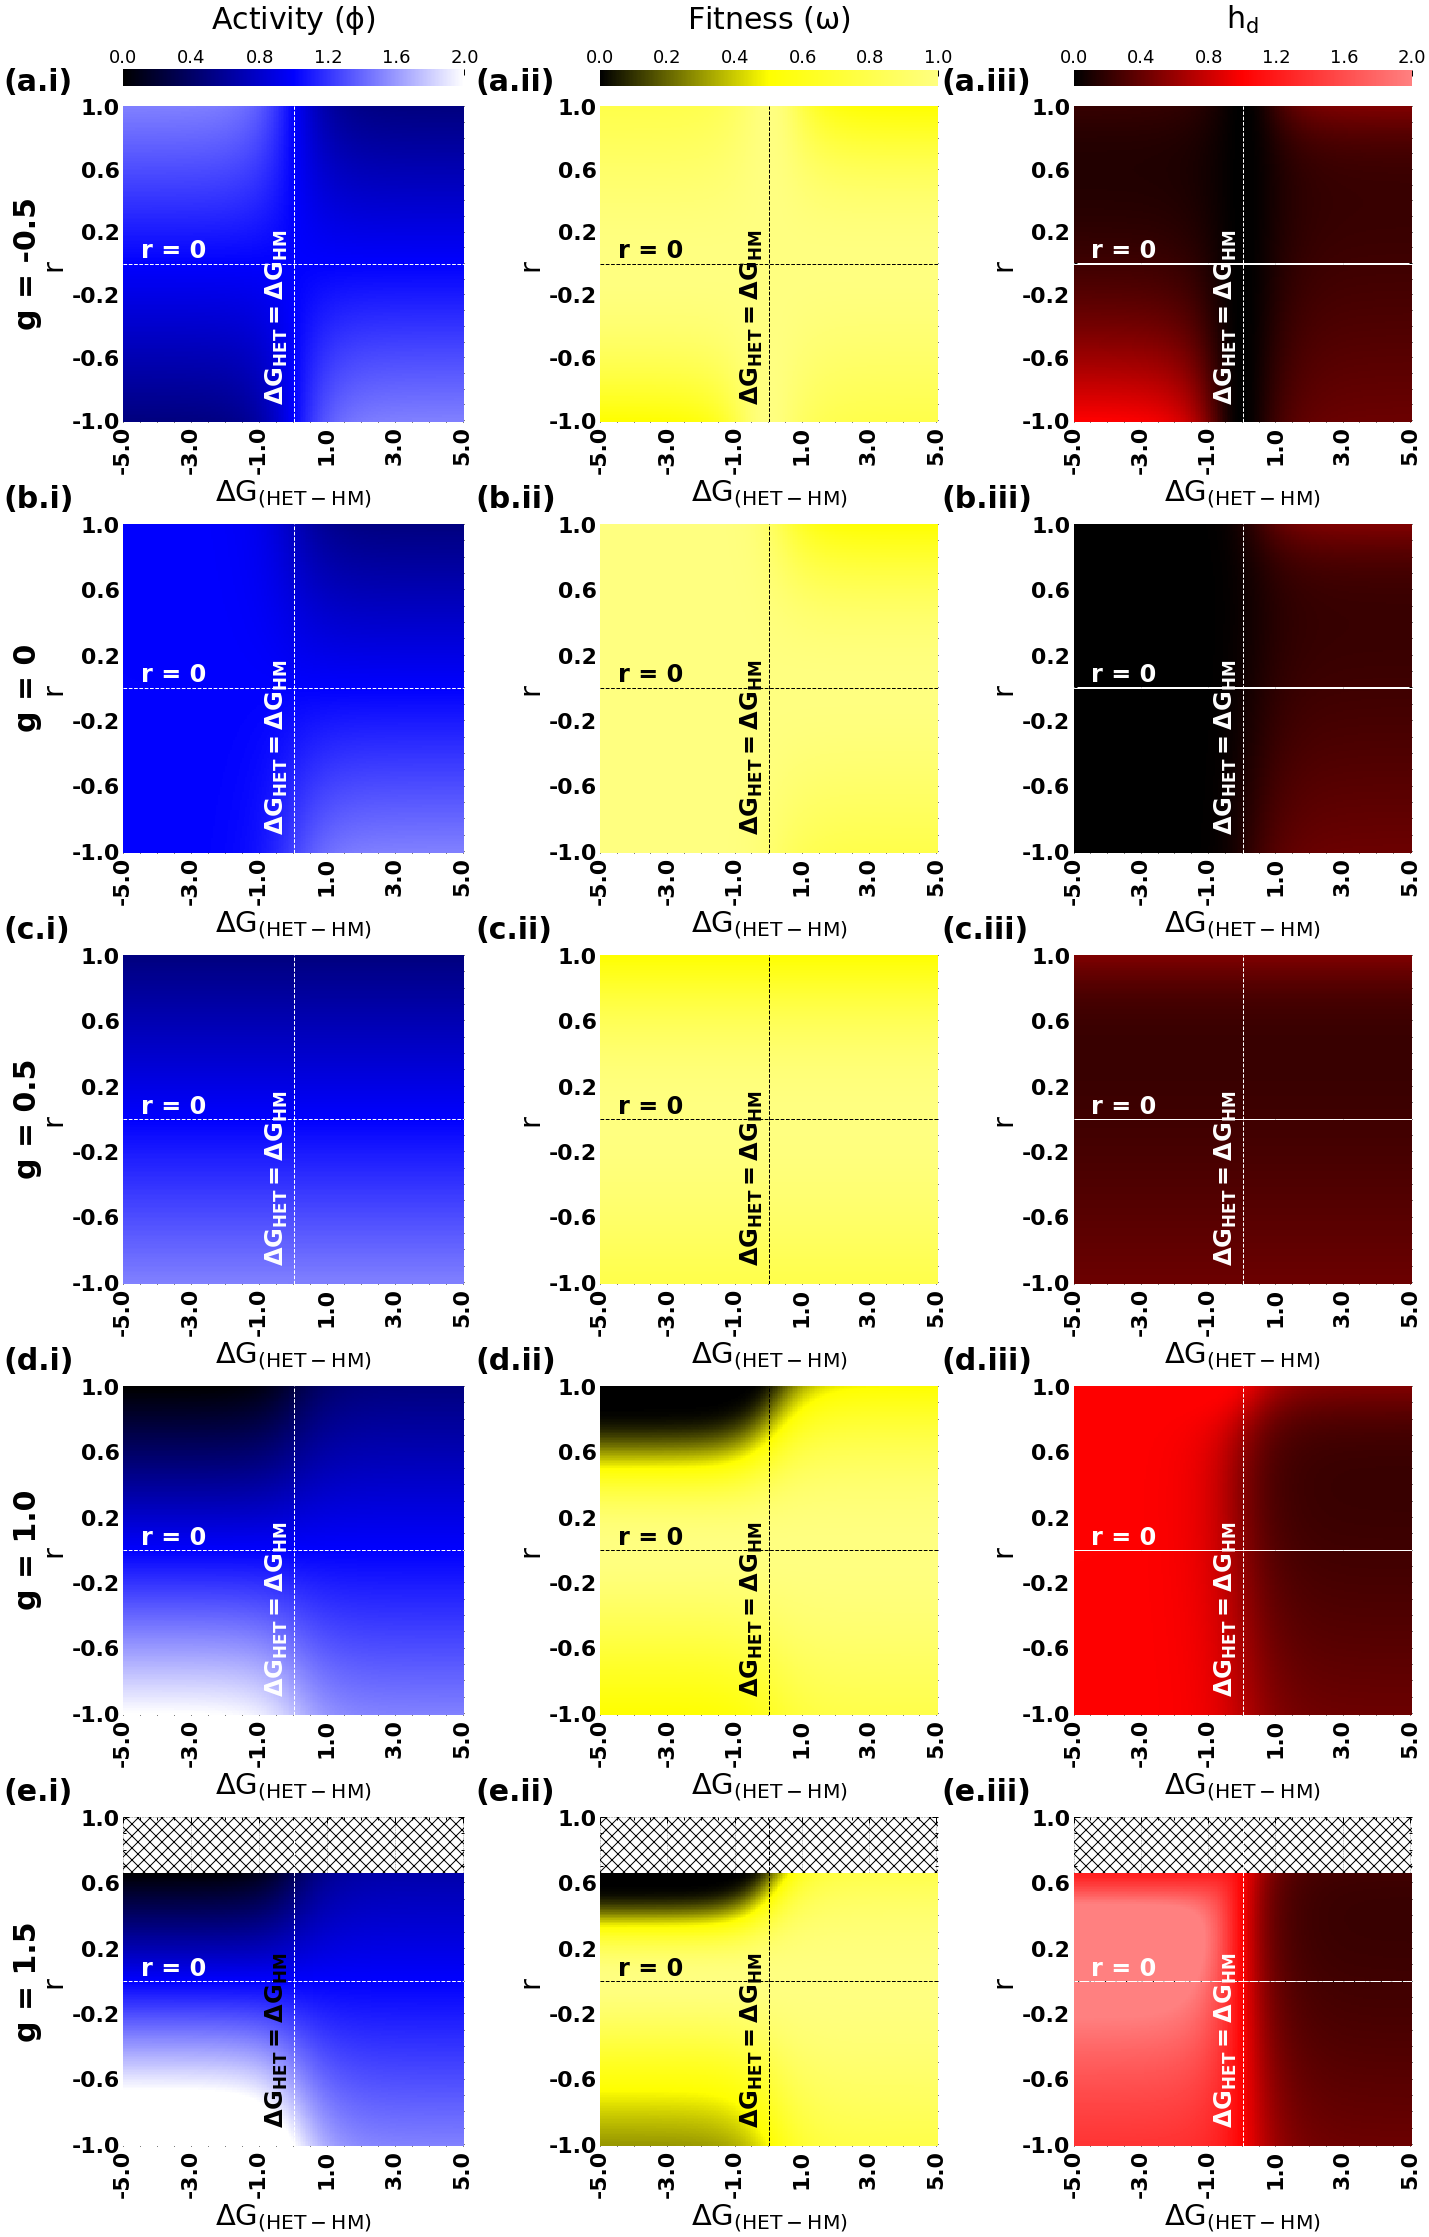

In [32]:
fig = plt.figure(figsize=(20,33))
gs = GridSpec(5, 3, figure=fig, height_ratios=[1.2, 1, 1, 1, 1], width_ratios=[1.01, 1, 1])

axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(5)])

romans1 = ['i','ii','iii']
alphabet1 = ['a','b','c','d','e']
panelnumbers = [[f'{x}.{y}' for y in romans1] for x in alphabet1]

cmap1 = LinearSegmentedColormap.from_list("cmap1", [(0.0,(0,0,0)),(0.5,(0,0,1)),(1.0,(1,1,1))])
cmap2 = LinearSegmentedColormap.from_list("cmap2", [(0.0,(0,0,0)),(0.5,(1,1,0)),(1.0,(1,1,0.5))])
cmap3 = LinearSegmentedColormap.from_list("cmap3", [(0.0,(0,0,0)),(0.5,(1,0,0)),(1.0,(1,0.5,0.5))])

xticks = np.arange(0, len(curr_binding_energy_AB_vals), 40)
xticklabels = np.round(curr_binding_energy_AB_vals[::40] - curr_binding_energy_AA, 1)
yticks = np.arange(0, len(r_vals), 40)
yticklabels = np.round(r_vals[::-40], 1)

# Plot heatmaps and configure subplots
for i in range(5):
    for j in range(3):
        ax = axs[i, j]

        # Select data and colormap
        if j == 0:
            data, cmap, vmin, vmax, label = activity_c1[i], cmap1, 0, 2, "Activity ($\\mathrm{\\phi}$)"
        elif j == 1:
            data, cmap, vmin, vmax, label = fitness_c1[i], cmap2, 0, 1, "Fitness ($\\mathrm{\\omega}$)"
        else:
            data, cmap, vmin, vmax, label = h_c1[i], cmap3, 0, 2, "$\\mathrm{h_d}$"

        if i == 0:
            cbar_kws = {'location': 'top'}
            sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, cbar_kws=cbar_kws, 
                       rasterized = True)

            # colorbar specifications
            cbar = ax.collections[0].colorbar
            cbar.set_label(label=label, fontsize=30, loc='center', labelpad=20)
            cbar.ax.tick_params(labelsize=18)
            cbar.locator = MaxNLocator(nbins=6)
            cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            for label in cbar.ax.get_yticklabels():
                label.set_fontweight('bold')

        elif i == 4:
            sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, cbar=False, zorder=2, 
                       rasterized = True)

            im = ax.pcolormesh(data, edgecolors='black', linewidths=0, zorder=1)
            ax.patch.set(hatch='xx', edgecolor='black')

        else:
            sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax, cbar=False, 
                       rasterized = True)

        ax.set_xticks(xticks, xticklabels, fontsize=22, fontweight='bold')
        ax.set_yticks(yticks, yticklabels, fontsize=22, fontweight='bold')

        ax.axvline(x=len(curr_binding_energy_AB_vals)/2, 
                   color='white' if (j in [0,2]) else 'black', 
                   linestyle='--', linewidth=1, label='$\Delta G_{(HET - HM)}$=0')
        
        ax.axhline(y=len(r_vals)/2, 
                   color='white' if (j in [0,2]) else 'black',
                   linestyle='--', linewidth=1, label='r=0')

        ax.text(len(curr_binding_energy_AB_vals)/2 - 10, len(r_vals) - 15,
                '$\mathbf{\Delta G_{HET} = \Delta G_{HM}}$',
                color='white' if ((j==0 and i < 4) or (j==2)) else 'black',
                ha='center', fontsize=24, fontweight='bold', rotation=90)
        ax.text(30, len(r_vals)/2 - 4, 'r = 0', 
                color='white' if (j in [0,2]) else 'black',
                ha='center', fontsize=24, fontweight='bold')

        ax.set_xlabel("$\mathrm{\Delta G_{(HET - HM)}}$", fontsize=29)
        ax.set_ylabel("r", fontsize=29)
        ax.annotate(f"({panelnumbers[i][j]})", xy=(-0.35 - 0.02*j, 1.05), xycoords="axes fraction", fontsize=30, fontweight='bold')

        if j == 0:
            ax.text(-65,100,f"g = {g_vals[i]}", color='black', va='center', rotation=90, fontsize=30, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.4)
plt.savefig("../Figures/Supp_figures/FigureS2.png", transparent=False, dpi=300, bbox_inches='tight')
plt.savefig("../Figures/Supp_figures/FigureS2.pdf", transparent=False, dpi=300, bbox_inches='tight')
plt.show()


## **Supplementary Video 1**

#### **Defining activity and fitness functions**

In [9]:
# defining the original fitness function for a list input of activity

def fitness_ln(activity, alpha=1, beta=0.5):
    fit_ln = []
    for act in activity:
        if act == None:
            fit_ln.append(None)
        else:
            fit_ln.append(beta**(np.log2(act/alpha)**2))

    return np.array(fit_ln)

# defining activity as a function of r and g,
# when synthesis and decay rates, folding and binding energies are uniform,
# and unit equilibrium conc. c = 1

def activity_WT(r_vals): # WT homozygous genotype
    act_WT = []
    for r in r_vals:
        if 1 - r >= 0:
            act_WT.append(1)
        else:
            act_WT.append(None)
    return np.array(act_WT)

def activity_homo_mut(r_vals): # Mutant homozygous genotype
    act_homo_mut = []
    for r in r_vals:
        if 1 - r >= 0:
            act_homo_mut.append(1 - r)
        else:
            act_homo_mut.append(None)
    return np.array(act_homo_mut)

def activity_m_hetero(r_vals): # Heterozygous monomer genotype
    act_m_hetero = []
    for r in r_vals:
        if 1 - r >= 0:
            act_m_hetero.append(1 - r/2)
        else:
            act_m_hetero.append(None)
    return np.array(act_m_hetero)

def activity_d_hetero(g_vals,r_vals): # Heterozygous dimer genotype
    act_d_hetero = []
    for g in g_vals:
        for r in r_vals:
            if 1 - r >= 0 and 1 - g*r >= 0:
                act_d_hetero.append(1 - g*r/2 - r/4)
            else:
                act_d_hetero.append(None)
    return np.array(act_d_hetero)

# defining fitness as a function of r and g,
# when synthesis and decay rates, folding and binding energies are uniform,
# and unit equilibrium conc. c = 1

def fitness_WT(r): # WT homozygous genotype
    return fitness_ln(activity_WT(r))

def fitness_homo_mut(r): # Mutant homozygous genotype
    return fitness_ln(activity_homo_mut(r))

def fitness_m_hetero(r): # Heterozygous monomer genotype
    return fitness_ln(activity_m_hetero(r))

def fitness_d_hetero(g,r): # Heterozygous dimer genotype
    return fitness_ln(activity_d_hetero(g,r))


#### **Animation**

[]

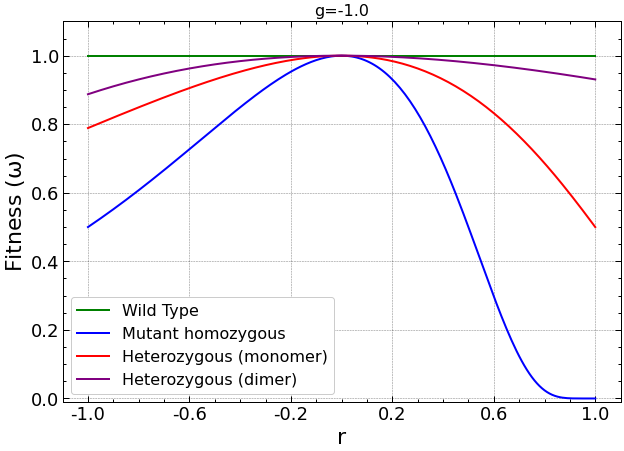

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

r_vals = np.linspace(-1,1,201)

# splitting the range of g-values into intervals, to simulate the animation pausing at important g values
important_g_vals = [-0.5, 0, 0.5, 1, 1.5]  # Points where animation "pauses"
repeats = 33

g_vals_f = np.linspace(-1, 2, 200)

for g in important_g_vals:
    g_vals_f = np.insert(g_vals_f, np.searchsorted(g_vals_f, g), [g] * repeats)

g_vals = np.concatenate((g_vals_f, g_vals_f[::-1]))

# axes ticks
xticks = np.linspace(-1,1,6)
xticklabels = np.round(xticks,1)
yticks = np.linspace(0,1,6)
yticklabels = np.round(yticks,1)

# y data (fitness for the 4 genotypes)
fit_aa = fitness_WT(r_vals)
fit_bb = fitness_homo_mut(r_vals)
fit_abm = fitness_m_hetero(r_vals)
fit_abd = np.reshape(fitness_d_hetero(g_vals, r_vals), (-1,len(r_vals))).tolist()

# plotting the three fixed fitness plots
ax.plot(r_vals, fit_aa, label="Wild Type", c="g")
ax.plot(r_vals, fit_bb, label="Mutant homozygous", c="b")
ax.plot(r_vals, fit_abm, label="Heterozygous (monomer)", c="r")

# plotting the animation for fitness of heterozygous dimer genotype
N = len(g_vals)
def update(frame, ax, line, xdata, ydata, tdata, anim=False):
    if line is None:
        line, = ax.plot(xdata, ydata[frame], label="Heterozygous (dimer)", c="purple")
    line.set_data(xdata, ydata[frame])
    ax.set_title(f"g={round(tdata[frame],1)}")
    return line,
line, = update(0, ax, None, r_vals, fit_abd, g_vals, True)

# axes labels
ax.set_xlabel("r", fontsize=22)
ax.set_ylabel("Fitness ($\mathrm{\omega}$)", fontsize=22)
ax.set_xticks(xticks, xticklabels, fontsize=18)
ax.set_yticks(yticks, yticklabels, fontsize=18)
ax.set_ylim(-0.01,1.1)
ax.legend()

update_anim = functools.partial(update, ax=ax, line=line,
                                xdata=r_vals, ydata=fit_abd, tdata=g_vals, anim=True)
ani = animation.FuncAnimation(fig, update_anim, N, interval=15, blit=False)

# save animation
ani.save('../Figures/Supp_figures/VideoS1.gif', writer='pillow')

plt.plot()